# **Preparing Data**

---



In [ ]:
# @title Getting dataset from The Stack

from datasets import load_dataset
import os

os.makedirs("dataset", exist_ok=True)

python_ds = load_dataset("bigcode/the-stack", data_dir="data/python", streaming=True, split="train")
js_ds = load_dataset("bigcode/the-stack", data_dir="data/javascript", streaming=True, split="train")

limit = 1000
python_count = 0
js_count = 0

for sample in python_ds:
    if python_count >= limit:
        break
    with open(f"dataset/{python_count}.py", "w", encoding="utf-8") as f:
        f.write(sample["content"])
    python_count += 1

for sample in js_ds:
    if js_count >= limit:
        break
    with open(f"dataset/{js_count}.js", "w", encoding="utf-8") as f:
        f.write(sample["content"])
    js_count += 1

print(f"Saved {python_count} Python files and {js_count} JS files.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/206 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/499 [00:00<?, ?it/s]

Saved 1000 Python files and 1000 JS files.


In [ ]:
# @title Extract code features

import os
import ast
import json
import numpy as np
from collections import Counter
import re


class CodeFeatureExtractor:

    def __init__(self):
        self.feature_names = [
            'lines_of_code',
            'num_functions',
            'num_classes',
            'num_loops',
            'num_conditions',
            'num_assignments',
            'num_imports',
            'num_operations',
            'num_returns',
            'num_try_except',
            'max_nesting_depth',
            'avg_function_length',
            'num_strings',
            'num_list_comp',
            'comment_ratio',
            'whitespace_ratio',
            'num_decorators',
            'num_lambdas',
            'num_exceptions',
            'complexity_score',
            'cyclomatic_complexity',
            'halstead_volume',
            'token_diversity',
            'avg_line_length',
            'indentation_variance'
        ]

    def extract_from_file(self, filepath):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                code = f.read()

            if filepath.endswith('.py'):
                return self._extract_python_features(code)
            elif filepath.endswith('.js'):
                return self._extract_javascript_features(code)
            else:
                return None

        except Exception as e:
            print(f"⚠️Error in {filepath}: {str(e)}")
            return None

    def _extract_python_features(self, code):
        features = [0] * 25

        try:
            tree = ast.parse(code)
            lines = code.split('\n')

            features[0] = len(lines)

            functions = [n for n in ast.walk(tree) if isinstance(n, ast.FunctionDef)]
            features[1] = len(functions)

            features[2] = len([n for n in ast.walk(tree) if isinstance(n, ast.ClassDef)])

            features[3] = len([n for n in ast.walk(tree)
                              if isinstance(n, (ast.For, ast.While))])

            features[4] = len([n for n in ast.walk(tree) if isinstance(n, ast.If)])

            features[5] = len([n for n in ast.walk(tree) if isinstance(n, ast.Assign)])

            features[6] = len([n for n in ast.walk(tree)
                              if isinstance(n, (ast.Import, ast.ImportFrom))])

            features[7] = len([n for n in ast.walk(tree) if isinstance(n, ast.BinOp)])

            features[8] = len([n for n in ast.walk(tree) if isinstance(n, ast.Return)])

            features[9] = len([n for n in ast.walk(tree) if isinstance(n, ast.Try)])

            features[10] = self._calculate_max_depth(tree)

            if functions:
                func_lengths = [len(ast.get_source_segment(code, f)) or 0
                              for f in functions]
                features[11] = np.mean([l for l in func_lengths if l > 0]) if func_lengths else 0
            else:
                features[11] = 0

            features[12] = len([n for n in ast.walk(tree)
                               if isinstance(n, ast.Constant)])

            features[13] = len([n for n in ast.walk(tree) if isinstance(n, ast.ListComp)])

            comment_lines = len([l for l in lines if l.strip().startswith('#')])
            features[14] = comment_lines / max(1, len(lines))

            whitespace = code.count(' ') + code.count('\t') + code.count('\n')
            features[15] = whitespace / max(1, len(code))

            decorators = sum(len(getattr(n, 'decorator_list', []))
                           for n in ast.walk(tree))
            features[16] = decorators

            features[17] = len([n for n in ast.walk(tree) if isinstance(n, ast.Lambda)])

            features[18] = len([n for n in ast.walk(tree) if isinstance(n, ast.Raise)])

            features[19] = features[3] + features[4] + features[9]  # loops + conditions + exceptions

            features[20] = self._calculate_cyclomatic_complexity(tree)

            halstead = self._calculate_halstead(code)
            features[21] = halstead

            tokens = re.findall(r'\b\w+\b', code)
            features[22] = len(set(tokens)) / max(1, len(tokens)) if tokens else 0

            line_lengths = [len(l) for l in lines if l.strip()]
            features[23] = np.mean(line_lengths) if line_lengths else 0

            indents = [len(l) - len(l.lstrip()) for l in lines if l.strip()]
            features[24] = np.std(indents) if indents else 0

        except SyntaxError:
            features[0] = len(code.split('\n'))
            features[14] = len([l for l in code.split('\n')
                               if l.strip().startswith('#')]) / max(1, features[0])
        except Exception as e:
            pass

        return features

    def _extract_javascript_features(self, code):
        features = [0] * 25
        lines = code.split('\n')

        features[0] = len(lines)

        features[1] = len(re.findall(r'function\s+\w+|=>\s*{|=>\s*\(', code))

        features[2] = len(re.findall(r'class\s+\w+', code))

        features[3] = len(re.findall(r'\b(for|while)\s*\(', code))

        features[4] = len(re.findall(r'\bif\s*\(', code))

        features[5] = len(re.findall(r'\b(var|let|const)\s+\w+', code))

        features[6] = len(re.findall(r'\b(import|require)\s*\(', code))

        features[7] = len(re.findall(r'[+\-*/]', code))

        features[8] = len(re.findall(r'\breturn\b', code))

        features[9] = len(re.findall(r'\btry\s*{', code))

        max_depth = 0
        current_depth = 0
        for char in code:
            if char == '{':
                current_depth += 1
                max_depth = max(max_depth, current_depth)
            elif char == '}':
                current_depth -= 1
        features[10] = max_depth

        comment_lines = len(re.findall(r'^\s*//|^\s*/\*', '\n'.join(lines), re.MULTILINE))
        features[14] = comment_lines / max(1, len(lines))

        whitespace = code.count(' ') + code.count('\t') + code.count('\n')
        features[15] = whitespace / max(1, len(code))

        tokens = re.findall(r'\b\w+\b', code)
        features[22] = len(set(tokens)) / max(1, len(tokens)) if tokens else 0

        line_lengths = [len(l) for l in lines if l.strip()]
        features[23] = np.mean(line_lengths) if line_lengths else 0

        return features

    def _calculate_max_depth(self, node, current_depth=0):
        max_depth = current_depth
        for child in ast.iter_child_nodes(node):
            child_depth = self._calculate_max_depth(child, current_depth + 1)
            max_depth = max(max_depth, child_depth)
        return max_depth

    def _calculate_cyclomatic_complexity(self, tree):
        decision_points = 0
        for node in ast.walk(tree):
            if isinstance(node, (ast.If, ast.While, ast.For, ast.ExceptHandler)):
                decision_points += 1
            elif isinstance(node, ast.BoolOp):
                decision_points += len(node.values) - 1

        return decision_points + 1

    def _calculate_halstead(self, code):
        operators = re.findall(r'[+\-*/=<>!&|]|\b(and|or|not|in|is)\b', code)
        operands = re.findall(r'\b\w+\b', code)

        n1 = len(set(operators))
        n2 = len(set(operands))
        N1 = len(operators)
        N2 = len(operands)

        if n1 == 0 or n2 == 0:
            return 0

        vocabulary = n1 + n2
        length = N1 + N2
        volume = length * np.log2(vocabulary) if vocabulary > 0 else 0

        return volume

    def extract_from_directory(self, directory, output_file='data/features.npy'):
        print(f"Extracting from: {directory}")

        features_list = []
        filenames = []
        failed = 0

        files = [f for f in os.listdir(directory)
                if f.endswith(('.py', '.js'))]

        for i, filename in enumerate(files):
            filepath = os.path.join(directory, filename)

            features = self.extract_from_file(filepath)

            if features is not None:
                features_list.append(features)
                filenames.append(filename)
                print(f" {i+1}/{len(files)}: {filename}", end='\r')
            else:
                failed += 1

        print(f"\n Features extracted from {len(features_list)} files")
        print(f"Failed: {failed} files")

        features_array = np.array(features_list)
        np.save(output_file, features_array)
        print(f"Saved features to: {output_file}")
        print(f"Data shape: {features_array.shape}")

        with open('data/filenames.json', 'w') as f:
            json.dump(filenames, f, indent=2)

        with open('data/feature_names.json', 'w') as f:
            json.dump(self.feature_names, f, indent=2)

        return features_array

    def print_feature_statistics(self, features_array):
        print("\n" + "="*60)
        print("Statistics")
        print("="*60)

        for i, name in enumerate(self.feature_names):
            values = features_array[:, i]
            print(f"{name:25s}: "
                  f"min={values.min():8.2f}, "
                  f"max={values.max():8.2f}, "
                  f"mean={values.mean():8.2f}, "
                  f"std={values.std():8.2f}")


def main():
    extractor = CodeFeatureExtractor()

    features = extractor.extract_from_directory('dataset')

    #features = extractor.extract_from_file('src/model.py')
    # print(np.array(features))
    #extractor.print_feature_statistics(features)


if __name__ == "__main__":
    main()


Feature Extractor Code
Extracting from: dataset


<unknown>:151: SyntaxWarning: invalid escape sequence '\w'
<unknown>:273: SyntaxWarning: invalid escape sequence '\('
<unknown>:279: SyntaxWarning: invalid escape sequence '\*'
<unknown>:285: SyntaxWarning: invalid escape sequence '\w'
<unknown>:310: SyntaxWarning: invalid escape sequence '\s'


<unknown>:137: SyntaxWarning: invalid escape sequence '\s'


<unknown>:1174: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1180: SyntaxWarning: invalid escape sequence '\='


<unknown>:141: SyntaxWarning: invalid escape sequence '\d'
<unknown>:54: SyntaxWarning: invalid escape sequence '\.'
<unknown>:80: SyntaxWarning: invalid escape sequence '\$'
<unknown>:166: SyntaxWarning: invalid escape sequence '\$'
<unknown>:174: SyntaxWarning: invalid escape sequence '\$'


<unknown>:185: SyntaxWarning: invalid escape sequence '\+'


<unknown>:27: SyntaxWarning: invalid escape sequence '\('


<unknown>:23: SyntaxWarning: invalid escape sequence '\d'
<unknown>:24: SyntaxWarning: invalid escape sequence '\d'


<unknown>:52: SyntaxWarning: invalid escape sequence '\d'
<unknown>:49: SyntaxWarning: invalid escape sequence '\d'


<unknown>:7: SyntaxWarning: invalid escape sequence '\.'


<unknown>:94: SyntaxWarning: invalid escape sequence '\s'
<unknown>:124: SyntaxWarning: invalid escape sequence '\['
<unknown>:125: SyntaxWarning: invalid escape sequence '\s'
<unknown>:126: SyntaxWarning: invalid escape sequence '\s'


<unknown>:152: SyntaxWarning: invalid escape sequence '\s'
<unknown>:848: SyntaxWarning: invalid escape sequence '\p'


<unknown>:79: SyntaxWarning: invalid escape sequence '\P'


✅ 2000/2000: 570.py
 Features extracted from 2000 files
⚠️Failed: 0 files
Saved features to: data/features.npy
Data shape: (2000, 25)


In [ ]:
# @title Cleaning data

import os
import re
import ast

SOURCE_DIR = "dataset/"
DEST_DIR = "dataset/clean_code"

def remove_python_comments_and_docstrings(source):
    try:
        tree = ast.parse(source)
    except SyntaxError:
        return source

    docstring_lines = set()
    for node in ast.walk(tree):
        if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef, ast.ClassDef, ast.Module)):
            doc = ast.get_docstring(node, clean=False)
            if doc and node.body:
                first = node.body[0]
                if hasattr(first, 'lineno') and hasattr(first, 'end_lineno'):
                    for i in range(first.lineno, first.end_lineno + 1):
                        docstring_lines.add(i)

    cleaned = []
    for lineno, line in enumerate(source.splitlines(), start=1):
        stripped = line.strip()
        if lineno in docstring_lines:
            continue
        if stripped.startswith("#"):
            continue
        cleaned.append(line)

    return "\n".join(cleaned)


def remove_js_comments(source):
    pattern = r'(/\*[\s\S]*?\*/)|(//[^\n]*)'
    return re.sub(pattern, '', source)


def clean_file(source_path, dest_path):
    with open(source_path, 'r', encoding='utf-8') as f:
        code = f.read()

    if source_path.endswith('.py'):
        cleaned = remove_python_comments_and_docstrings(code)
    elif source_path.endswith('.js'):
        cleaned = remove_js_comments(code)
    else:
        return

    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    with open(dest_path, 'w', encoding='utf-8') as f:
        f.write(cleaned)


def traverse_and_clean(source_dir, dest_dir):
    for root, _, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('.py', '.js')):
                src_path = os.path.join(root, file)
                rel_path = os.path.relpath(src_path, source_dir)
                dst_path = os.path.join(dest_dir, rel_path)
                clean_file(src_path, dst_path)


if __name__ == "__main__":
    traverse_and_clean(SOURCE_DIR, DEST_DIR)
    print(f"Cleaned files saved to: {DEST_DIR}")


Code Features Visualizer
Loaded 1000 Python files and 1000 JavaScript files

CODE FEATURES ANALYSIS REPORT

Dataset Overview:
  Total files: 2000
  Python files: 1000
  JavaScript files: 1000

Python Statistics:
  lines_of_code            : mean=  226.89, std=  529.58
  num_functions            : mean=    9.52, std=   25.99
  num_classes              : mean=    1.73, std=    5.86
  num_loops                : mean=    2.46, std=    6.73
  num_conditions           : mean=    9.53, std=   36.94
  num_assignments          : mean=   36.28, std=   95.43
  num_imports              : mean=    5.39, std=    6.19
  num_operations           : mean=   10.87, std=   87.20
  num_returns              : mean=    6.82, std=   23.98
  num_try_except           : mean=    0.81, std=    2.89

JavaScript Statistics:
  lines_of_code            : mean=  189.11, std=  915.20
  num_functions            : mean=    7.16, std=   28.57
  num_classes              : mean=    0.30, std=    1.57
  num_loops            

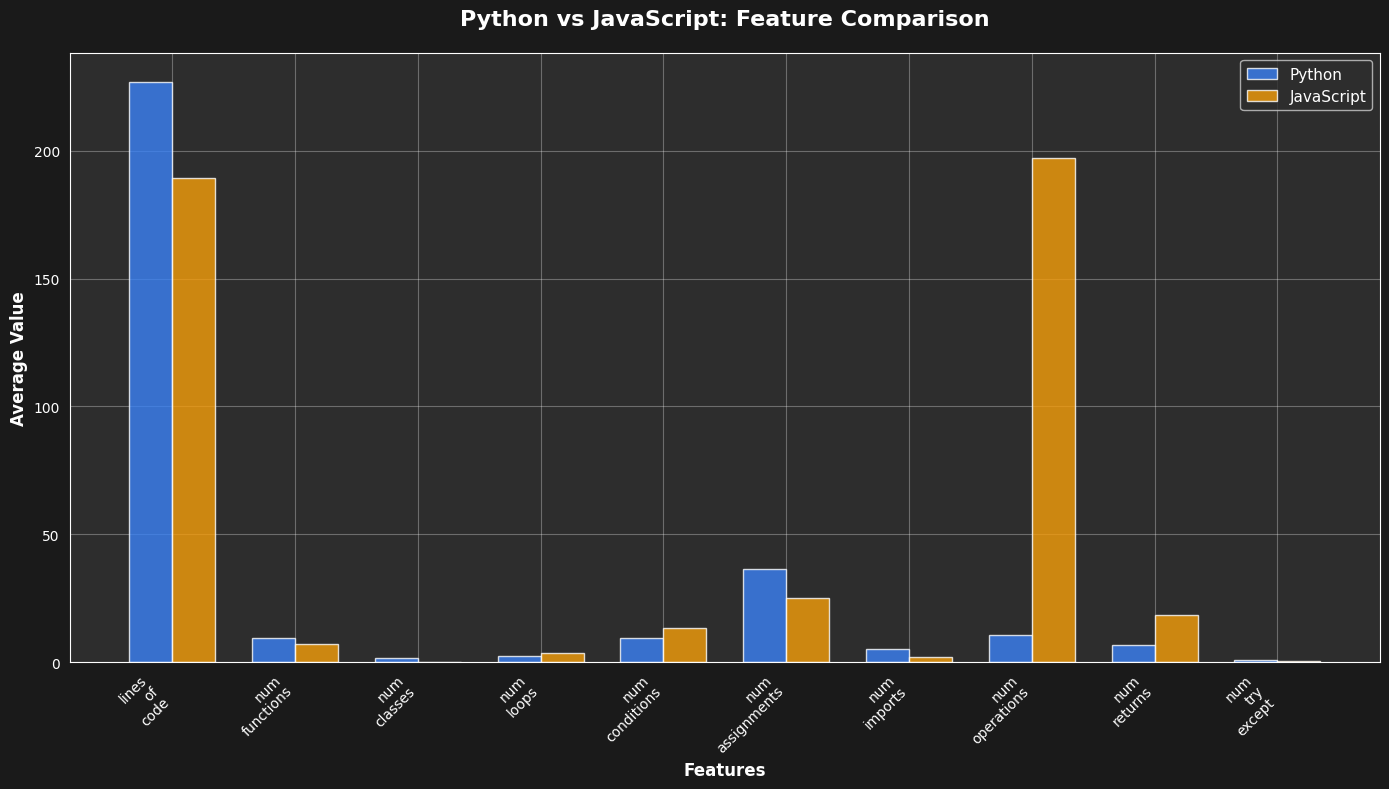

/tmp/ipython-input-1844115420.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True,
/tmp/ipython-input-1844115420.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True,
/tmp/ipython-input-1844115420.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True,
/tmp/ipython-input-1844115420.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11

Saved: complexity_comparison.png


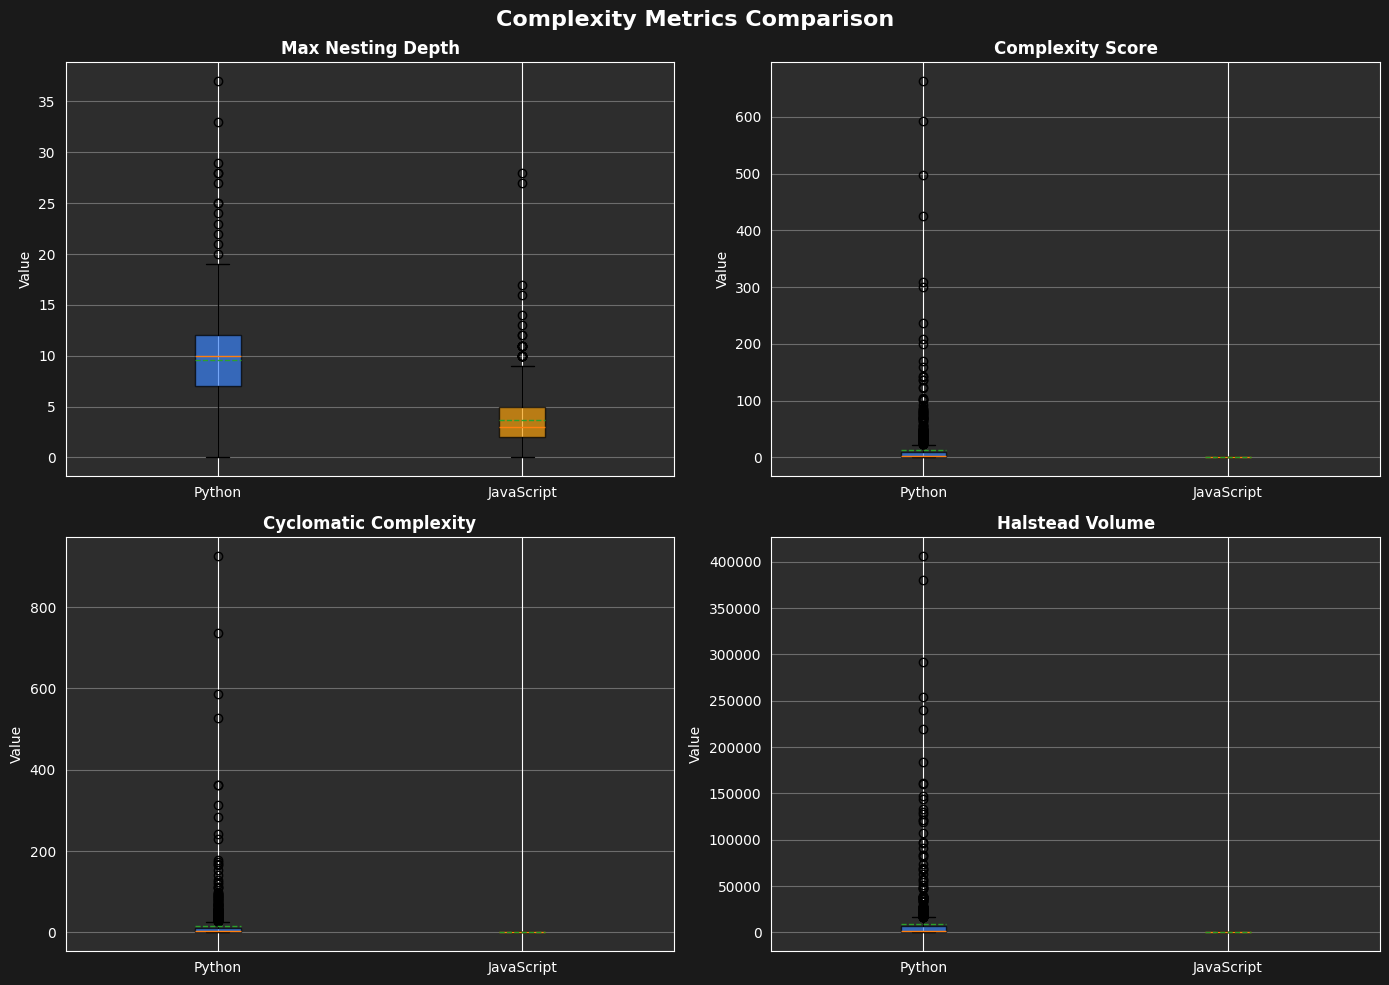

Saved: distribution_lines_of_code.png


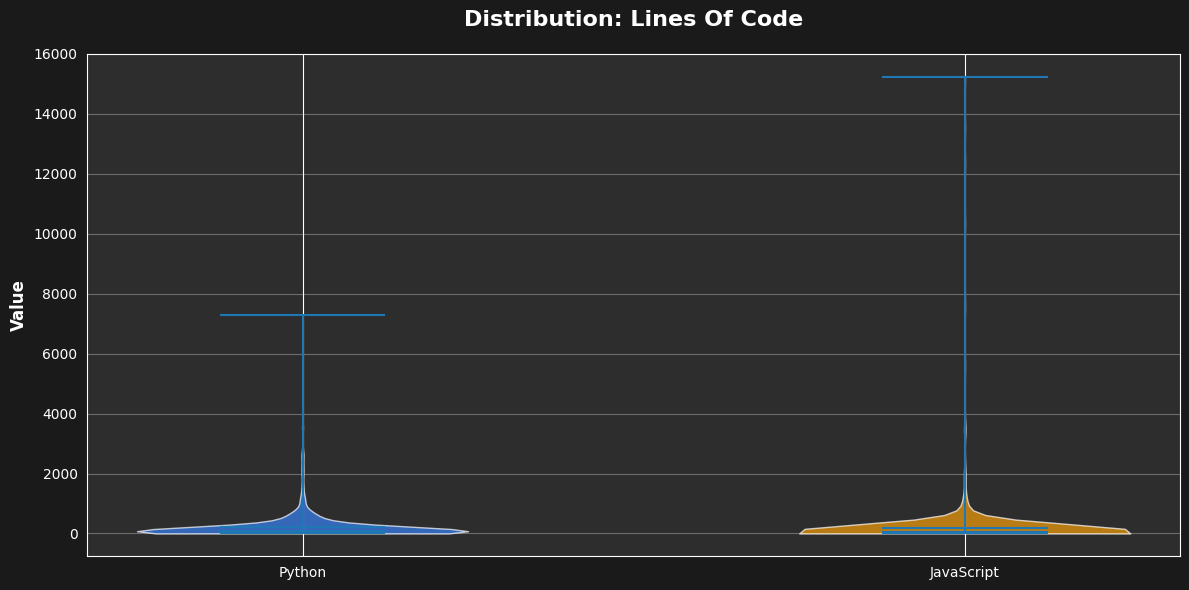

Saved: features_heatmap.png


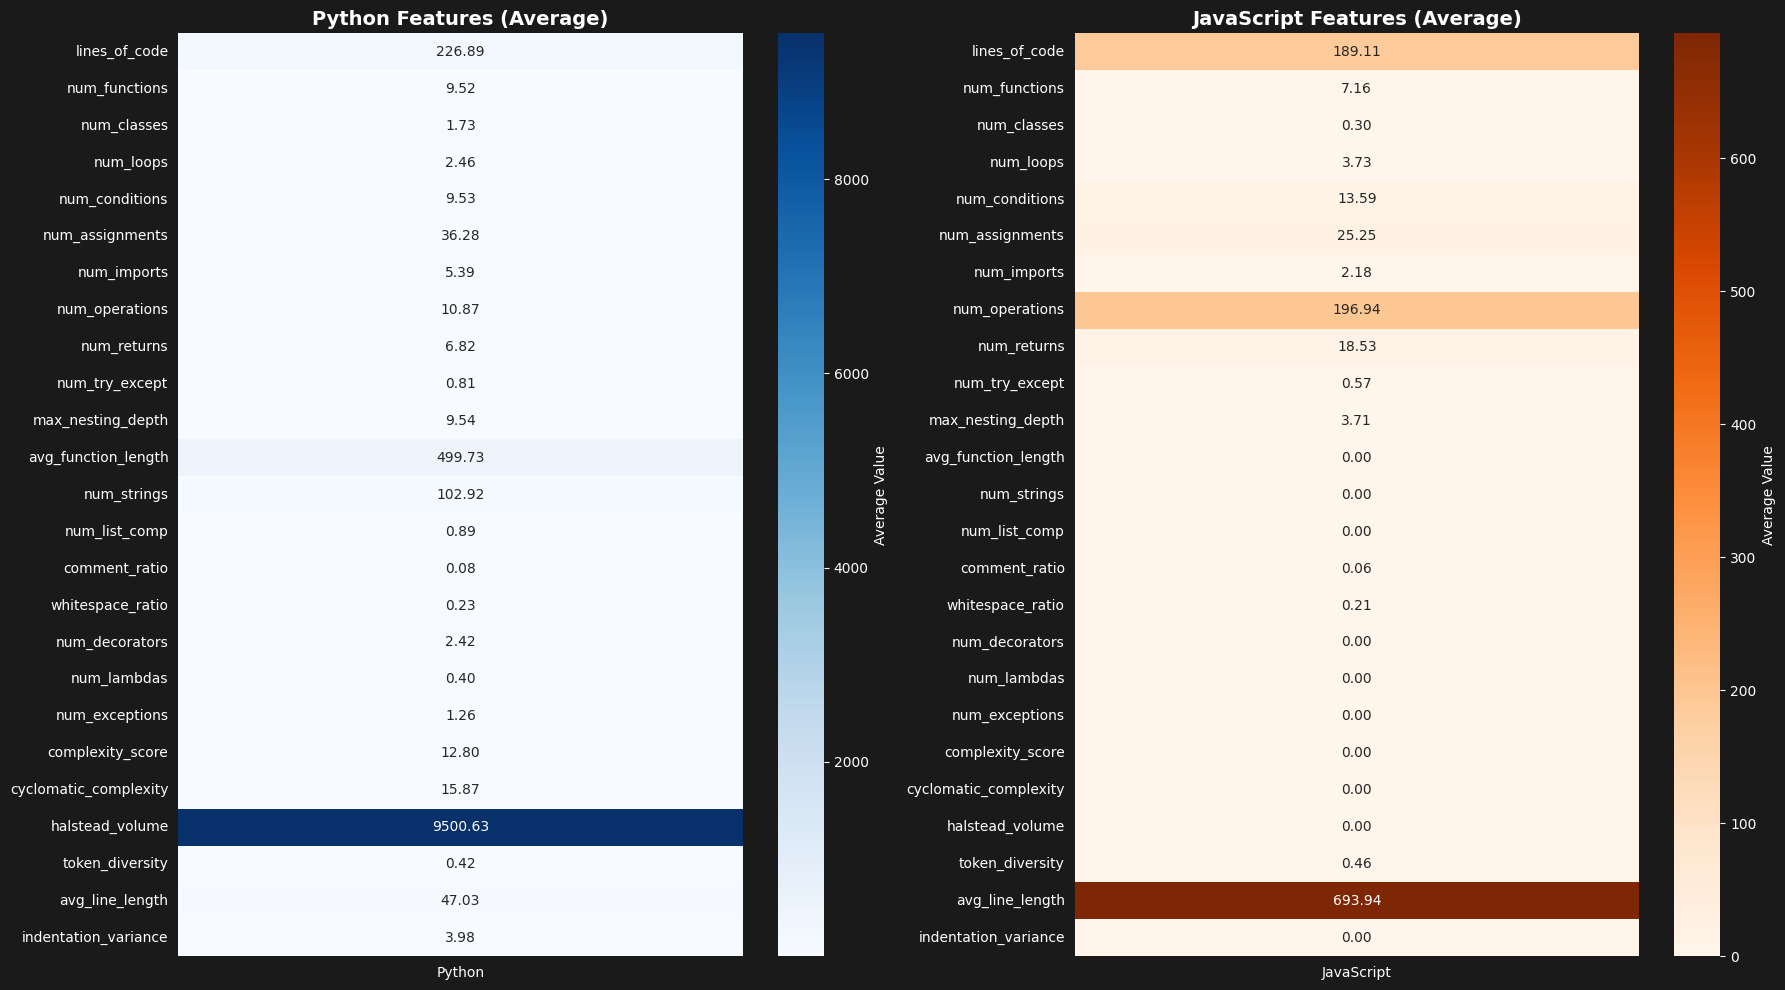

Saved: scatter_matrix.png


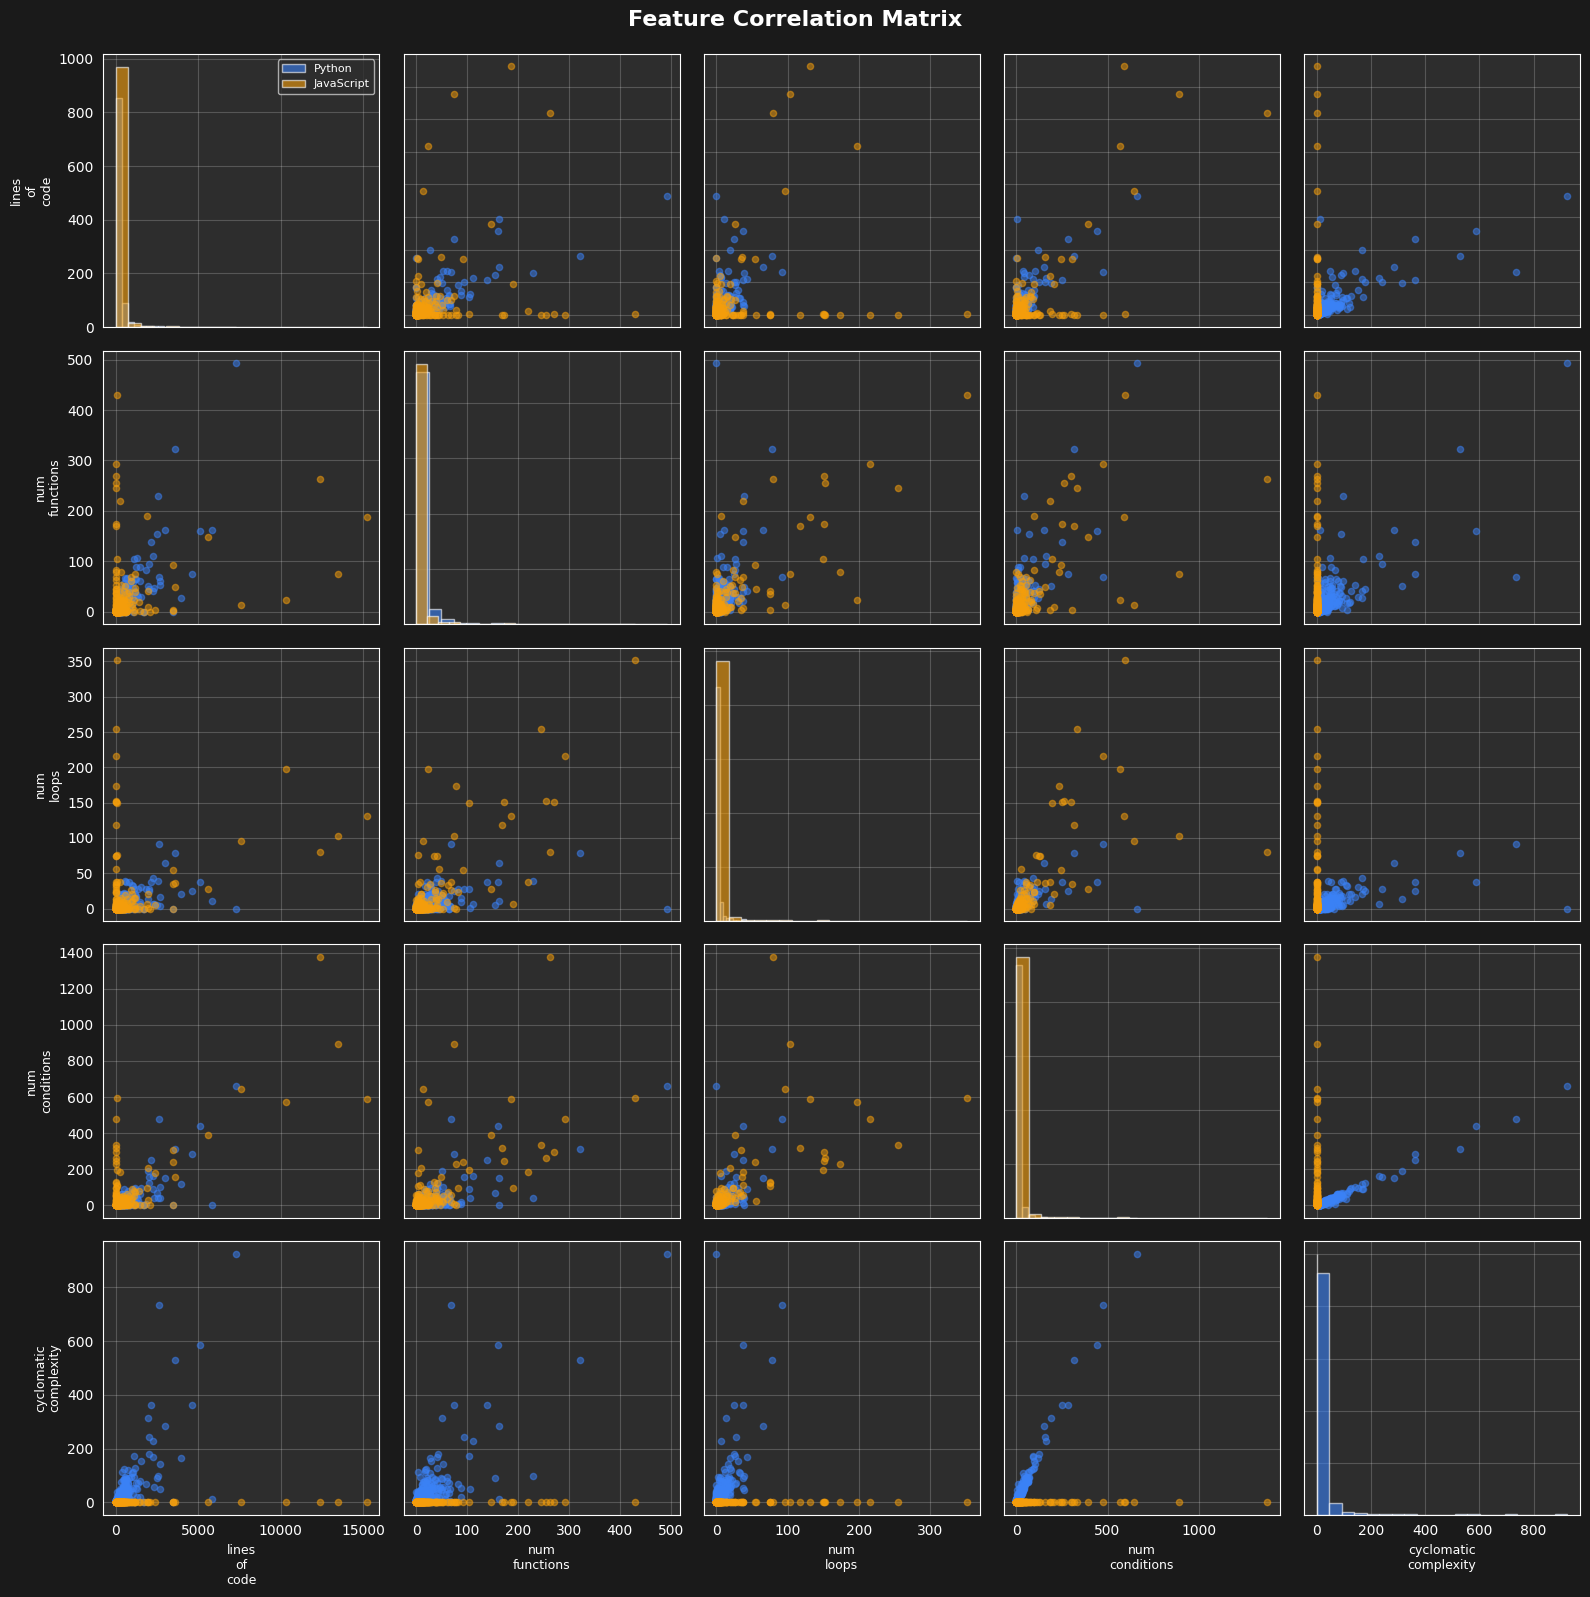


✅ All visualizations generated successfully!


In [ ]:
# @title Visualize data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = '#1a1a1a'
plt.rcParams['axes.facecolor'] = '#2d2d2d'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

class CodeFeaturesVisualizer:
    def __init__(self, features_path='data/features.npy',
                 filenames_path='data/filenames.json',
                 feature_names_path='data/feature_names.json'):

        self.features = np.load(features_path)

        with open(filenames_path, 'r') as f:
            self.filenames = json.load(f)

        with open(feature_names_path, 'r') as f:
            self.feature_names = json.load(f)

        self.py_indices = [i for i, name in enumerate(self.filenames) if name.endswith('.py')]
        self.js_indices = [i for i, name in enumerate(self.filenames) if name.endswith('.js')]

        self.py_features = self.features[self.py_indices] if self.py_indices else np.array([])
        self.js_features = self.features[self.js_indices] if self.js_indices else np.array([])

        print(f"Loaded {len(self.py_indices)} Python files and {len(self.js_indices)} JavaScript files")

    def plot_comparison_bars(self, feature_indices=None):
        if feature_indices is None:
            feature_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

        fig, ax = plt.subplots(figsize=(14, 8))

        feature_subset = [self.feature_names[i] for i in feature_indices]

        py_means = [np.mean(self.py_features[:, i]) if len(self.py_features) > 0 else 0
                    for i in feature_indices]
        js_means = [np.mean(self.js_features[:, i]) if len(self.js_features) > 0 else 0
                    for i in feature_indices]

        x = np.arange(len(feature_subset))
        width = 0.35

        bars1 = ax.bar(x - width/2, py_means, width, label='Python', color='#3b82f6', alpha=0.8)
        bars2 = ax.bar(x + width/2, js_means, width, label='JavaScript', color='#f59e0b', alpha=0.8)

        ax.set_xlabel('Features', fontsize=12, fontweight='bold')
        ax.set_ylabel('Average Value', fontsize=12, fontweight='bold')
        ax.set_title('Python vs JavaScript: Feature Comparison', fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels([name.replace('_', '\n') for name in feature_subset], rotation=45, ha='right')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_comparison.png', dpi=300, facecolor='#1a1a1a')
        print("Saved: feature_comparison.png")
        plt.show()

    def plot_distribution_violin(self, feature_idx=0):
        fig, ax = plt.subplots(figsize=(12, 6))

        data_to_plot = []
        labels = []

        if len(self.py_features) > 0:
            data_to_plot.append(self.py_features[:, feature_idx])
            labels.append('Python')

        if len(self.js_features) > 0:
            data_to_plot.append(self.js_features[:, feature_idx])
            labels.append('JavaScript')

        parts = ax.violinplot(data_to_plot, showmeans=True, showmedians=True)

        colors = ['#3b82f6', '#f59e0b']
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)

        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax.set_title(f'Distribution: {self.feature_names[feature_idx].replace("_", " ").title()}',
                     fontsize=16, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig(f'distribution_{self.feature_names[feature_idx]}.png', dpi=300, facecolor='#1a1a1a')
        print(f"Saved: distribution_{self.feature_names[feature_idx]}.png")
        plt.show()

    def plot_heatmap(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

        # Python heatmap
        if len(self.py_features) > 0:
            py_means = np.mean(self.py_features, axis=0).reshape(-1, 1)
            sns.heatmap(py_means, annot=True, fmt='.2f', cmap='Blues',
                       yticklabels=self.feature_names, xticklabels=['Python'],
                       ax=ax1, cbar_kws={'label': 'Average Value'})
            ax1.set_title('Python Features (Average)', fontsize=14, fontweight='bold', color='white')

        # JavaScript heatmap
        if len(self.js_features) > 0:
            js_means = np.mean(self.js_features, axis=0).reshape(-1, 1)
            sns.heatmap(js_means, annot=True, fmt='.2f', cmap='Oranges',
                       yticklabels=self.feature_names, xticklabels=['JavaScript'],
                       ax=ax2, cbar_kws={'label': 'Average Value'})
            ax2.set_title('JavaScript Features (Average)', fontsize=14, fontweight='bold', color='white')

        plt.tight_layout()
        plt.savefig('features_heatmap.png', dpi=300, facecolor='#1a1a1a')
        print("Saved: features_heatmap.png")
        plt.show()

    def plot_complexity_metrics(self):
        complexity_indices = [10, 19, 20, 21]
        complexity_names = [self.feature_names[i] for i in complexity_indices]

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        for idx, (feat_idx, name) in enumerate(zip(complexity_indices, complexity_names)):
            ax = axes[idx]

            data = []
            labels = []
            colors = []

            if len(self.py_features) > 0:
                data.append(self.py_features[:, feat_idx])
                labels.append('Python')
                colors.append('#3b82f6')

            if len(self.js_features) > 0:
                data.append(self.js_features[:, feat_idx])
                labels.append('JavaScript')
                colors.append('#f59e0b')

            bp = ax.boxplot(data, labels=labels, patch_artist=True,
                           showmeans=True, meanline=True)

            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            ax.set_title(name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            ax.set_ylabel('Value', fontsize=10)
            ax.grid(True, alpha=0.3, axis='y')

        plt.suptitle('Complexity Metrics Comparison', fontsize=16, fontweight='bold', color='white')
        plt.tight_layout()
        plt.savefig('complexity_comparison.png', dpi=300, facecolor='#1a1a1a')
        print("Saved: complexity_comparison.png")
        plt.show()

    def plot_scatter_matrix(self, feature_indices=[0, 1, 3, 4, 20]):
        feature_subset = [self.feature_names[i] for i in feature_indices]

        fig, axes = plt.subplots(len(feature_indices), len(feature_indices),
                                figsize=(16, 16))

        for i, feat_i in enumerate(feature_indices):
            for j, feat_j in enumerate(feature_indices):
                ax = axes[i, j]

                if i == j:
                    # Diagonal: histograms
                    if len(self.py_features) > 0:
                        ax.hist(self.py_features[:, feat_i], alpha=0.6, color='#3b82f6',
                               bins=20, label='Python')
                    if len(self.js_features) > 0:
                        ax.hist(self.js_features[:, feat_i], alpha=0.6, color='#f59e0b',
                               bins=20, label='JavaScript')
                    if i == 0:
                        ax.legend(fontsize=8)
                else:
                    # Off-diagonal: scatter plots
                    if len(self.py_features) > 0:
                        ax.scatter(self.py_features[:, feat_j], self.py_features[:, feat_i],
                                 alpha=0.5, color='#3b82f6', s=20)
                    if len(self.js_features) > 0:
                        ax.scatter(self.js_features[:, feat_j], self.js_features[:, feat_i],
                                 alpha=0.5, color='#f59e0b', s=20)

                if i == len(feature_indices) - 1:
                    ax.set_xlabel(feature_subset[j].replace('_', '\n'), fontsize=9)
                else:
                    ax.set_xticklabels([])

                if j == 0:
                    ax.set_ylabel(feature_subset[i].replace('_', '\n'), fontsize=9)
                else:
                    ax.set_yticklabels([])

                ax.grid(True, alpha=0.2)

        plt.suptitle('Feature Correlation Matrix', fontsize=16, fontweight='bold',
                    color='white', y=0.995)
        plt.tight_layout()
        plt.savefig('scatter_matrix.png', dpi=300, facecolor='#1a1a1a')
        print("Saved: scatter_matrix.png")
        plt.show()

    def generate_summary_report(self):

        print(f"Total files: {len(self.filenames)}")
        print(f"  Python files: {len(self.py_indices)}")
        print(f"  JavaScript files: {len(self.js_indices)}")

        if len(self.py_features) > 0:
            print(f"\nPython Statistics:")
            for i, name in enumerate(self.feature_names[:10]):
                values = self.py_features[:, i]
                print(f"  {name:25s}: mean={np.mean(values):8.2f}, std={np.std(values):8.2f}")

        if len(self.js_features) > 0:
            print(f"\nJavaScript Statistics:")
            for i, name in enumerate(self.feature_names[:10]):
                values = self.js_features[:, i]
                print(f"  {name:25s}: mean={np.mean(values):8.2f}, std={np.std(values):8.2f}")


def main():
    print("Code Features Visualizer")
    viz = CodeFeaturesVisualizer()
    viz.generate_summary_report()

    print("\nGenerating visualizations...")
    viz.plot_comparison_bars(feature_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    viz.plot_complexity_metrics()

    viz.plot_distribution_violin(feature_idx=0)

    viz.plot_heatmap()

    viz.plot_scatter_matrix(feature_indices=[0, 1, 3, 4, 20])


if __name__ == "__main__":
    main()


# **Training**


---



In [ ]:
# @title Good Numbers, Bad Images!

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



FEATURE_NAMES = [
    "lines_of_code", "num_functions", "num_classes", "num_loops",
    "num_conditions", "num_assignments", "num_imports", "num_operations",
    "num_returns", "num_try_except", "max_nesting_depth", "avg_function_length",
    "num_strings", "num_list_comp", "comment_ratio", "whitespace_ratio",
    "num_decorators", "num_lambdas", "num_exceptions", "complexity_score",
    "cyclomatic_complexity", "halstead_volume", "token_diversity",
    "avg_line_length", "indentation_variance"
]



class CodeToImageDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]


class Generator(nn.Module):
    def __init__(self, input_dim=25, image_size=32):
        super().__init__()
        self.image_size = image_size

        self.structure_idx = [0, 1, 2, 10, 19, 20]
        self.control_idx = [3, 4, 9]
        self.operations_idx = [5, 7, 8, 6]
        self.style_idx = [14, 15, 24, 23]
        self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]

        self.low_freq_encoder = nn.Sequential(
            nn.Linear(len(self.structure_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.mid_freq_encoder = nn.Sequential(
            nn.Linear(len(self.control_idx) + len(self.operations_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.high_freq_encoder = nn.Sequential(
            nn.Linear(len(self.style_idx) + len(self.advanced_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.color_palette_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.Tanh(),
            nn.Linear(128, 12)  # 4 colors × 3 channels
        )

        self.composition_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 6)
        )

        self.low_to_spatial = nn.Linear(512, 8 * 8 * 128)
        self.mid_to_spatial = nn.Linear(512, 16 * 16 * 64)
        self.high_to_spatial = nn.Linear(512, 32 * 32 * 32)

        self.low_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        self.mid_decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        self.high_decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        # Fusion network
        self.fusion = nn.Sequential(
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.GroupNorm(8, 32),
            nn.GELU(),
            nn.Conv2d(32, 3, 1)
        )

        # Perlin noise generator
        self.noise_strength = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def generate_perlin_noise(self, batch_size, size, device):
        grid_size = 4
        grid = torch.randn(batch_size, 2, grid_size, grid_size, device=device)
        noise = F.interpolate(grid, size=(size, size), mode='bicubic', align_corners=True)
        return noise[:, 0:1]

    def apply_color_palette(self, grayscale, palette):
        batch_size = grayscale.size(0)
        palette = palette.view(batch_size, 4, 3)

        gray_norm = (grayscale + 1) / 2

        colors = []
        for i in range(3):
            channel_colors = palette[:, :, i]
            stops = torch.linspace(0, 1, 4, device=grayscale.device)

            result = torch.zeros_like(gray_norm)
            for j in range(3):
                mask = (gray_norm >= stops[j]) & (gray_norm < stops[j+1])
                t = (gray_norm - stops[j]) / (stops[j+1] - stops[j] + 1e-8)
                result += mask * (channel_colors[:, j:j+1, None, None] * (1-t) +
                                 channel_colors[:, j+1:j+2, None, None] * t)

            mask_last = gray_norm >= stops[-1]
            result += mask_last * channel_colors[:, -1:, None, None]

            colors.append(result)

        return torch.cat(colors, dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        structure = x[:, self.structure_idx]
        control = x[:, self.control_idx]
        operations = x[:, self.operations_idx]
        style = x[:, self.style_idx]
        advanced = x[:, self.advanced_idx]

        low_freq = self.low_freq_encoder(structure)
        mid_freq = self.mid_freq_encoder(torch.cat([control, operations], dim=1))
        high_freq = self.high_freq_encoder(torch.cat([style, advanced], dim=1))

        palette = self.color_palette_net(x)

        composition_params = self.composition_net(low_freq)
        composition_params = torch.tanh(composition_params)

        low_spatial = self.low_to_spatial(low_freq).view(batch_size, 128, 8, 8)
        mid_spatial = self.mid_to_spatial(mid_freq).view(batch_size, 64, 16, 16)
        high_spatial = self.high_to_spatial(high_freq).view(batch_size, 32, 32, 32)

        low_decoded = self.low_decoder(low_spatial)
        mid_decoded = self.mid_decoder(mid_spatial)
        high_decoded = self.high_decoder(high_spatial)

        theta = composition_params[:, 3:4]
        scale = 0.5 + composition_params[:, 2:3]
        tx, ty = composition_params[:, 0:1], composition_params[:, 1:2]

        cos_t = torch.cos(theta * 3.14159)
        sin_t = torch.sin(theta * 3.14159)
        affine_matrix = torch.zeros(batch_size, 2, 3, device=device)
        affine_matrix[:, 0, 0] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 1] = -sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 0] = sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 1] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 2] = tx.squeeze()
        affine_matrix[:, 1, 2] = ty.squeeze()

        grid = F.affine_grid(affine_matrix, low_decoded.size(), align_corners=False)
        low_decoded = F.grid_sample(low_decoded, grid, align_corners=False, padding_mode='reflection')

        merged = torch.cat([low_decoded, mid_decoded, high_decoded], dim=1)
        fused = self.fusion(merged)

        noise_scale = self.noise_strength(x)
        perlin = self.generate_perlin_noise(batch_size, 32, device)
        perlin = perlin.expand(-1, 3, -1, -1)
        fused = fused + noise_scale.view(-1, 1, 1, 1) * perlin * 0.3

        grayscale = fused.mean(dim=1, keepdim=True)

        colored = self.apply_color_palette(grayscale, palette)

        output = torch.tanh(colored)

        return output



def feature_consistency_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    feat_dists = torch.cdist(features, features)
    img_flat = images.view(batch_size, -1)
    img_dists = torch.cdist(img_flat, img_flat)
    feat_dists = feat_dists / (feat_dists.max() + 1e-8)
    img_dists = img_dists / (img_dists.max() + 1e-8)

    consistency = F.mse_loss(feat_dists, img_dists)

    return consistency


def feature_variance_preservation_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    total_loss = 0
    count = 0
    num_features = features.size(1)

    sample_indices = torch.randperm(num_features, device=features.device)[:5]

    for i in sample_indices:
        feature_var = features[:, i].var()

        if feature_var > 0.01:
            sorted_indices = torch.argsort(features[:, i])
            sorted_images = images[sorted_indices]


            img_diffs = (sorted_images[1:] - sorted_images[:-1]).abs().mean()
            loss_term = -torch.log(img_diffs + 0.1)
            total_loss += loss_term
            count += 1

    return total_loss / max(count, 1)


def frequency_coherence_loss(images):
    fft = torch.fft.fft2(images)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)

    h, w = images.shape[2:]
    cy, cx = h // 2, w // 2

    y, x = torch.meshgrid(torch.arange(h, device=images.device),
                          torch.arange(w, device=images.device),
                          indexing='ij')
    dist = torch.sqrt((y - cy)**2.0 + (x - cx)**2.0)

    low_mask = (dist < h * 0.15).float()
    high_mask = (dist > h * 0.4).float()

    low_energy = (magnitude * low_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])
    high_energy = (magnitude * high_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])

    # low_energy >> high_energy
    target_ratio = 3.0
    ratio = low_energy / (high_energy + 1e-6)

    return F.relu(target_ratio - ratio).mean()


def color_harmony_loss(images):
    #Penalize excessive color variance (enforce palette constraint)
    color_var = images.var(dim=[2, 3]).mean()

    # encourage smooth color gradients
    color_grad_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    color_grad_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()

    return 0.5 * color_var + 0.1 * (color_grad_h + color_grad_w)


def texture_diversity_loss(images):
    textures = []
    for scale in [1, 2, 4]:
        if scale > 1:
            scaled = F.avg_pool2d(images, scale)
        else:
            scaled = images

        # Calculate variance at this scale
        variance = (scaled - scaled.mean(dim=[2, 3], keepdim=True)).pow(2).mean(dim=[2, 3])
        textures.append(variance)

    texture_stack = torch.stack(textures, dim=1)

    # HIGH diversity (different textures at different scales)
    diversity = texture_stack.std(dim=1).mean()

    # Penalize LOW diversity (all scales look the same)
    return F.relu(0.05 - diversity)


def combined_aesthetic_loss(features, images):
    consistency = feature_consistency_loss(features, images)
    variance = feature_variance_preservation_loss(features, images)
    freq_coherence = frequency_coherence_loss(images)
    color_harmony = color_harmony_loss(images)
    texture_div = texture_diversity_loss(images)

    # Total variation
    tv_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    tv_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()
    smoothness = tv_h + tv_w

    total = (
        5.0 * consistency +
        0.2 * variance +
        1.0 * freq_coherence +
        0.3 * color_harmony +
        5.0 * texture_div +
        0.1 * smoothness
    )

    return total, {
        'consistency': consistency.item(),
        'variance': variance.item(),
        'freq_coherence': freq_coherence.item(),
        'color_harmony': color_harmony.item(),
        'texture_div': texture_div.item(),
        'smoothness': smoothness.item()
    }



def hsv_to_rgb(h, s, v):
    import colorsys
    return np.array(colorsys.hsv_to_rgb(h, s, v))


def create_feature_explanation_grid(model, features, save_path):
    model.eval()
    base_idx = 42
    base_features = features[base_idx].copy()

    feature_indices = [0, 3, 10, 14, 19, 24]
    feature_names = [FEATURE_NAMES[i] for i in feature_indices]

    fig, axes = plt.subplots(len(feature_indices), 5, figsize=(15, 3*len(feature_indices)))

    for row, feat_idx in enumerate(feature_indices):
        variations = []
        for multiplier in [-2, -1, 0, 1, 2]:
            varied = base_features.copy()
            varied[feat_idx] += multiplier * features[:, feat_idx].std()
            variations.append(varied)

        with torch.no_grad():
            x = torch.FloatTensor(variations).to(next(model.parameters()).device)
            images = model(x).cpu()

        for col, img_tensor in enumerate(images):
            img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(f"{[-2,-1,0,1,2][col]}σ", fontsize=10)

        axes[row, 0].set_ylabel(feature_names[row], fontsize=10, rotation=0,
                                ha='right', va='center')

    plt.suptitle("Feature Influence Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


class Trainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.loss_components = {
            'consistency': [],
            'variance': [],
            'freq_coherence': [],
            'color_harmony': [],
            'texture_div': [],
            'smoothness': []
        }

    def train_epoch(self, loader, optimizer):
        self.model.train()
        total_loss = 0
        epoch_components = {k: 0 for k in self.loss_components.keys()}

        for features in loader:
            features = features.to(self.device)
            optimizer.zero_grad()

            images = self.model(features)
            loss, components = combined_aesthetic_loss(features, images)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            for key in components:
                epoch_components[key] += components[key]

        avg_loss = total_loss / len(loader)
        self.train_losses.append(avg_loss)

        for key in epoch_components:
            self.loss_components[key].append(epoch_components[key] / len(loader))

        return avg_loss, epoch_components

    def train(self, train_loader, epochs=200, lr=5e-4):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            betas=(0.5, 0.999),
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=20,  #  every 20 epochs
            T_mult=2,  # double the period after each restart
            eta_min=1e-6
        )

        print(f"Training on {self.device}...")
        for epoch in range(epochs):
            avg_loss, components = self.train_epoch(train_loader, optimizer)
            scheduler.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")
                print(f"  Consistency: {components['consistency']:.4f}, "
                      f"Variance: {components['variance']:.4f}")
                print(f"  FreqCoherence: {components['freq_coherence']:.4f}, "
                      f"ColorHarmony: {components['color_harmony']:.4f}")
                print(f"  TextureDiv: {components['texture_div']:.4f}, "
                      f"Smoothness: {components['smoothness']:.4f}")

        print("Training complete.")

    def save_model(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            "state_dict": self.model.state_dict(),
            "train_losses": self.train_losses,
            "loss_components": self.loss_components
        }, path)
        print(f"Model saved to {path}")

    def plot_losses(self, save_path='results/loss.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].plot(self.train_losses, linewidth=2, color='blue')
        axes[0].set_title("Training Loss (Total)", fontsize=14, fontweight='bold')
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True, alpha=0.3)

        for key, values in self.loss_components.items():
            axes[1].plot(values, label=key, linewidth=1.5)
        axes[1].set_title("Loss Components", fontsize=14, fontweight='bold')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Loss plot saved to {save_path}")

    def generate_samples(self, features, n=25, save_path='results/samples.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()
        with torch.no_grad():
            x = torch.FloatTensor(features[:n]).to(self.device)
            images = self.model(x).cpu()

        rows = int(np.sqrt(n))
        cols = (n + rows - 1) // rows
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        axes = axes.flatten()

        for i in range(n):
            img = (images[i].permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis("off")

        for i in range(n, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Samples saved to {save_path}")

    def test_feature_consistency(self, features, save_path='results/consistency_test.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()

        base_indices = [0, 50, 100, 150, 199]

        fig, axes = plt.subplots(5, 5, figsize=(12, 12))

        for row, base_idx in enumerate(base_indices):
            base_features = features[base_idx]

            similarities = []
            for i in range(len(features)):
                if i != base_idx:
                    sim = np.dot(features[i], base_features) / (
                        np.linalg.norm(features[i]) * np.linalg.norm(base_features) + 1e-8
                    )
                    similarities.append((i, sim))

            similarities.sort(key=lambda x: x[1], reverse=True)
            similar_indices = [base_idx] + [idx for idx, _ in similarities[:4]]

            with torch.no_grad():
                x = torch.FloatTensor(features[similar_indices]).to(self.device)
                images = self.model(x).cpu()

            for col, img_tensor in enumerate(images):
                img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
                img = np.clip(img, 0, 1)
                axes[row, col].imshow(img)
                axes[row, col].axis("off")
                if col == 0:
                    axes[row, col].set_title("Base", fontsize=10, fontweight='bold')
                else:
                    axes[row, col].set_title(f"Sim: {similarities[col-1][1]:.2f}", fontsize=8)

        plt.suptitle("Feature Consistency Test", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Consistency test saved to {save_path}")



def prepare_data_loaders(features, batch_size=32):
    dataset = CodeToImageDataset(features)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded: {len(dataset)} samples")
    return loader



def main():
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)


    # Load features
    features_path = "data/features.npy"
    if not os.path.exists(features_path):
        raise FileNotFoundError(f"{features_path} not found")
    features = np.load(features_path)
    features = (features - features.mean(0)) / (features.std(0) + 1e-8)
    print(f"Features shape: {features.shape}")

    # Prepare data
    loader = prepare_data_loaders(features, batch_size=32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Initialize mode
    model = Generator(input_dim=features.shape[1], image_size=32)
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {param_count:,}")

    # Train model
    trainer = Trainer(model, device=device)
    trainer.train(loader, epochs=100, lr=1e-3)

    # Save results
    trainer.save_model("models/code2art.pth")
    trainer.plot_losses("results/losses.png")
    trainer.generate_samples(features, n=25, save_path="results/samples.png")
    trainer.test_feature_consistency(features, save_path="results/consistency.png")


if __name__ == "__main__":
    main()

FIXED Code-to-Image Generator
Balanced loss components + log-space variance

[1/5] Loading features...
Features shape: (2000, 25)

[2/5] Preparing data loaders...
Dataset loaded: 2000 samples
Device: cuda

[3/5] Initializing model...
Model parameters: 30,241,590

[4/5] Training model...
Training on cuda...
FIXED: Balanced loss weights + log-space variance loss
Epoch [10/100] - Loss: 0.2615
  Consistency: 0.9469, Variance: 47.0386
  FreqCoherence: 0.0241, ColorHarmony: 5.1646
  TextureDiv: 0.0068, Smoothness: 7.2442
Epoch [20/100] - Loss: 0.2478
  Consistency: 0.7496, Variance: 48.3698
  FreqCoherence: 0.0057, ColorHarmony: 4.8149
  TextureDiv: 0.0122, Smoothness: 6.7846
Epoch [30/100] - Loss: 0.2485
  Consistency: 0.7756, Variance: 48.0316
  FreqCoherence: 0.0138, ColorHarmony: 4.8475
  TextureDiv: 0.0115, Smoothness: 6.4507
Epoch [40/100] - Loss: 0.2434
  Consistency: 0.6916, Variance: 48.6297
  FreqCoherence: 0.0146, ColorHarmony: 4.7456
  TextureDiv: 0.0173, Smoothness: 6.2440
Epoch

In [ ]:
# @title First Working 32px model

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


FEATURE_NAMES = [
    "lines_of_code", "num_functions", "num_classes", "num_loops",
    "num_conditions", "num_assignments", "num_imports", "num_operations",
    "num_returns", "num_try_except", "max_nesting_depth", "avg_function_length",
    "num_strings", "num_list_comp", "comment_ratio", "whitespace_ratio",
    "num_decorators", "num_lambdas", "num_exceptions", "complexity_score",
    "cyclomatic_complexity", "halstead_volume", "token_diversity",
    "avg_line_length", "indentation_variance"
]



class CodeToImageDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]


class Generator(nn.Module):
    """
    Generates images with controlled chaos through:
     Frequency-domain decomposition (low/mid/high)
     Spatial composition layers
     Feature-dependent color palettes
     Texture injection at multiple scales
    """
    def __init__(self, input_dim=25, image_size=32):
        super().__init__()
        self.image_size = image_size

        # Feature grouping (keep your existing groups)
        self.structure_idx = [0, 1, 2, 10, 19, 20]
        self.control_idx = [3, 4, 9]
        self.operations_idx = [5, 7, 8, 6]
        self.style_idx = [14, 15, 24, 23]
        self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]

        # Low-freq: overall composition, large shapes (structure features)
        self.low_freq_encoder = nn.Sequential(
            nn.Linear(len(self.structure_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        # Mid-freq: patterns, textures (control + operations)
        self.mid_freq_encoder = nn.Sequential(
            nn.Linear(len(self.control_idx) + len(self.operations_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        # High-freq: details, noise (style + advanced)
        self.high_freq_encoder = nn.Sequential(
            nn.Linear(len(self.style_idx) + len(self.advanced_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        #  Color palette generator
        self.color_palette_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.Tanh(),
            nn.Linear(128, 12)  # 4 colors × 3 channels (HSV or RGB)
        )

        # Controls WHERE patterns appear (position, scale, rotation)
        self.composition_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 6)  # [center_x, center_y, scale, rotation, flow_x, flow_y]
        )

        # Projection to spatial maps (separate for each frequency)
        self.low_to_spatial = nn.Linear(512, 8 * 8 * 128)
        self.mid_to_spatial = nn.Linear(512, 16 * 16 * 64)
        self.high_to_spatial = nn.Linear(512, 32 * 32 * 32)

        # CHANGE 4: Multi-scale decoder with residual connections
        # Low-frequency path (8x8 -> 32x32)
        self.low_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8->16
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16->32
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        # Mid-frequency path (16x16 -> 32x32)
        self.mid_decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16->32
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        # High-frequency path (already 32x32)
        self.high_decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.GroupNorm(8, 32),
            nn.GELU()
        )

        # CHANGE 5: Fusion network with learned frequency weighting
        self.fusion = nn.Sequential(
            nn.Conv2d(96, 64, 3, 1, 1),  # 32+32+32 channels
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.GroupNorm(8, 32),
            nn.GELU(),
            nn.Conv2d(32, 3, 1)
        )

        # CHANGE 6: Perlin noise generator (controlled chaos)
        self.noise_strength = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def generate_perlin_noise(self, batch_size, size, device):
        # Simple implementation: interpolated random gradients
        grid_size = 4
        grid = torch.randn(batch_size, 2, grid_size, grid_size, device=device)
        noise = F.interpolate(grid, size=(size, size), mode='bicubic', align_corners=True)
        return noise[:, 0:1]  # Single channel

    def apply_color_palette(self, grayscale, palette):
        batch_size = grayscale.size(0)
        palette = palette.view(batch_size, 4, 3)  # 4 colors, 3 channels

        # Normalize grayscale to [0, 1]
        gray_norm = (grayscale + 1) / 2

        # Multi-stop gradient mapping
        colors = []
        for i in range(3):  # RGB channels
            channel_colors = palette[:, :, i]  # (batch, 4)
            stops = torch.linspace(0, 1, 4, device=grayscale.device)

            # Interpolate between color stops
            result = torch.zeros_like(gray_norm)
            for j in range(3):
                mask = (gray_norm >= stops[j]) & (gray_norm < stops[j+1])
                t = (gray_norm - stops[j]) / (stops[j+1] - stops[j] + 1e-8)
                result += mask * (channel_colors[:, j:j+1, None, None] * (1-t) +
                                 channel_colors[:, j+1:j+2, None, None] * t)

            mask_last = gray_norm >= stops[-1]
            result += mask_last * channel_colors[:, -1:, None, None]

            colors.append(result)

        return torch.cat(colors, dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        # Extract feature groups
        structure = x[:, self.structure_idx]
        control = x[:, self.control_idx]
        operations = x[:, self.operations_idx]
        style = x[:, self.style_idx]
        advanced = x[:, self.advanced_idx]

        # Encode to frequency bands
        low_freq = self.low_freq_encoder(structure)
        mid_freq = self.mid_freq_encoder(torch.cat([control, operations], dim=1))
        high_freq = self.high_freq_encoder(torch.cat([style, advanced], dim=1))

        # Generate color palette
        palette = self.color_palette_net(x)

        # Generate composition parameters
        composition_params = self.composition_net(low_freq)
        composition_params = torch.tanh(composition_params)

        # Project to spatial maps
        low_spatial = self.low_to_spatial(low_freq).view(batch_size, 128, 8, 8)
        mid_spatial = self.mid_to_spatial(mid_freq).view(batch_size, 64, 16, 16)
        high_spatial = self.high_to_spatial(high_freq).view(batch_size, 32, 32, 32)

        # Decode each frequency band
        low_decoded = self.low_decoder(low_spatial)
        mid_decoded = self.mid_decoder(mid_spatial)
        high_decoded = self.high_decoder(high_spatial)

        # Apply spatial transformations based on composition params
        # (rotation, translation via grid_sample)
        theta = composition_params[:, 3:4]  # rotation
        scale = 0.5 + composition_params[:, 2:3]  # scale
        tx, ty = composition_params[:, 0:1], composition_params[:, 1:2]

        cos_t = torch.cos(theta * 3.14159)
        sin_t = torch.sin(theta * 3.14159)
        affine_matrix = torch.zeros(batch_size, 2, 3, device=device)
        affine_matrix[:, 0, 0] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 1] = -sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 0] = sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 1] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 2] = tx.squeeze()
        affine_matrix[:, 1, 2] = ty.squeeze()

        grid = F.affine_grid(affine_matrix, low_decoded.size(), align_corners=False)
        low_decoded = F.grid_sample(low_decoded, grid, align_corners=False, padding_mode='reflection')

        # Merge frequency bands
        merged = torch.cat([low_decoded, mid_decoded, high_decoded], dim=1)
        fused = self.fusion(merged)  # (batch, 3, 32, 32)

        # Add controlled Perlin noise for organic texture
        noise_scale = self.noise_strength(x)
        perlin = self.generate_perlin_noise(batch_size, 32, device)
        perlin = perlin.expand(-1, 3, -1, -1)
        fused = fused + noise_scale.view(-1, 1, 1, 1) * perlin * 0.3

        # Convert to grayscale for palette mapping
        grayscale = fused.mean(dim=1, keepdim=True)

        # Apply feature-driven color palette
        colored = self.apply_color_palette(grayscale, palette)

        # Final normalization
        output = torch.tanh(colored)

        return output


def feature_consistency_loss(features, images, top_k=5, alpha=1.0):
    batch_size = features.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=features.device)

    # 1. Calculate Pairwise Feature Distances (Euclidean)
    # Norm calculation (B, 1) - dist_sq = ||f_i||^2 + ||f_j||^2 - 2 * f_i * f_j.T
    features_norm_sq = torch.sum(features**2, dim=1, keepdim=True)
    # Pairwise feature distance squared (B, B)
    feature_dist_sq = features_norm_sq + features_norm_sq.transpose(0, 1) - 2.0 * torch.matmul(features, features.transpose(0, 1))

    # Set diagonal to infinity to exclude self-comparison
    feature_dist_sq.fill_diagonal_(float('inf'))

    # 2. Find Top-K Nearest Feature Neighbors
    # feature_dist_sq is size (B, B). Each row i is distance from feature i to all features j.
    # Returns (values, indices), both (B, top_k)
    # We ignore the distance values and only need the indices
    _, nn_indices = torch.topk(feature_dist_sq, top_k, dim=1, largest=False)

    # 3. Calculate Pairwise Image Distances (L2/MSE)
    # Reshape images to (B, C*H*W)
    images_flat = images.view(batch_size, -1)
    images_norm_sq = torch.sum(images_flat**2, dim=1, keepdim=True)

    # Pairwise image distance squared (B, B)
    image_dist_sq = images_norm_sq + images_norm_sq.transpose(0, 1) - 2.0 * torch.matmul(images_flat, images_flat.transpose(0, 1))

    # 4. Calculate Consistency Loss
    consistency_loss = torch.tensor(0.0, device=features.device)

    # Iterate over each sample in the batch
    for i in range(batch_size):
        # Get the k-nearest feature indices for sample i
        nn_idx = nn_indices[i]

        # Get the feature and image distances for these neighbors
        f_dists = torch.sqrt(feature_dist_sq[i, nn_idx])
        i_dists = torch.sqrt(image_dist_sq[i, nn_idx])

        # The loss is the L1 difference between the normalized image difference and the normalized feature difference.

        # Penalize visual difference (i_dists)
        # loss_i = RELU(i_dists - alpha * f_dists).mean()
        # Encourages i_dist < alpha*f_dist

        # Minimize the difference in the ratios.
        ratio = i_dists / (f_dists + 1e-6)

        # Loss is the mean squared error of the ratio from the target alpha
        loss_i = F.mse_loss(ratio, torch.full_like(ratio, alpha), reduction='mean')

        consistency_loss += loss_i

    return consistency_loss / batch_size


def frequency_coherence_loss(images):
    # FFT decomposition
    fft = torch.fft.fft2(images)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)

    h, w = images.shape[2:]
    cy, cx = h // 2, w // 2

    # Create frequency masks
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y, x = y.to(images.device), x.to(images.device)
    dist = torch.sqrt((y - cy)**2 + (x - cx)**2)

    low_mask = (dist < h * 0.15).float()
    high_mask = (dist > h * 0.4).float()

    # Penalize weak low frequencies and excessive high frequencies
    low_energy = (magnitude * low_mask).sum(dim=[2, 3])
    high_energy = (magnitude * high_mask).sum(dim=[2, 3])

    target_ratio = 3.0  # Low freq should be 3x stronger than high freq
    return F.relu(high_energy - low_energy / target_ratio).mean()


def color_harmony_loss(images):
    batch_size = images.size(0)

    # Convert to LAB-like space (approximation)
    r, g, b = images[:, 0], images[:, 1], images[:, 2]
    l = 0.299 * r + 0.587 * g + 0.114 * b

    # Penalize high color variance (enforce palette constraint)
    color_var = images.var(dim=[2, 3]).mean()

    # Encourage smooth color gradients
    color_grad_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    color_grad_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()

    return 0.5 * color_var + 0.1 * (color_grad_h + color_grad_w)


def texture_diversity_loss(images):
    textures = []
    for scale in [1, 2, 4]:
        if scale > 1:
            scaled = F.avg_pool2d(images, scale)
        else:
            scaled = images

        variance = (scaled - scaled.mean(dim=[2, 3], keepdim=True)).pow(2).mean(dim=[2, 3])
        textures.append(variance)

    texture_stack = torch.stack(textures, dim=1)
    diversity = texture_stack.std(dim=1).mean()
    #Penalize LOW diversity instead of high
    # Want diversity > 0, so minimize negative diversity
    return F.relu(0.1 - diversity)  # Penalize if diversity < 0.1


def combined_aesthetic_loss(features, images):

    # This encourages a much larger visual change for a small feature change.
    consistency = feature_consistency_loss(features, images, alpha=10.0)

    variance = feature_variance_preservation_loss(features, images)
    freq_coherence = frequency_coherence_loss(images)
    color_harmony = color_harmony_loss(images)
    texture_div = texture_diversity_loss(images)

    tv_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    tv_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()
    smoothness = tv_h + tv_w

    total = (
        1.0 * consistency +
        0.001 * variance +
        0.5 * freq_coherence +
        0.5 * color_harmony +
        0.1 * texture_div +
        0.2 * smoothness
    )

    return total, {
        'consistency': consistency.item(),
        'variance': variance.item(),
        'freq_coherence': freq_coherence.item(),
        'color_harmony': color_harmony.item(),
        'texture_div': texture_div.item(),
        'smoothness': smoothness.item()
    }

def frequency_coherence_loss(images):
    fft = torch.fft.fft2(images)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)

    h, w = images.shape[2:]
    cy, cx = h // 2, w // 2

    y, x = torch.meshgrid(torch.arange(h, device=images.device),
                          torch.arange(w, device=images.device),
                          indexing='ij')
    dist = torch.sqrt((y - cy)**2.0 + (x - cx)**2.0)

    low_mask = (dist < h * 0.15).float()
    high_mask = (dist > h * 0.4).float()

    low_energy = (magnitude * low_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])
    high_energy = (magnitude * high_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])

    # Encourage low >> high, penalize when high is too strong
    target_ratio = 3.0
    ratio = low_energy / (high_energy + 1e-6)

    # Loss increases when ratio < target_ratio
    return F.relu(target_ratio - ratio).mean()


def feature_variance_preservation_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    total_loss = 0
    count = 0
    num_features = features.size(1)
    sample_indices = torch.randperm(num_features, device=features.device)[:min(5, num_features)]  # Reduced from 10

    for i in sample_indices:
        feature_var = features[:, i].var()

        if feature_var > 0.01:
            sorted_indices = torch.argsort(features[:, i])
            sorted_images = images[sorted_indices]
            img_diffs = (sorted_images[1:] - sorted_images[:-1]).pow(2).mean()

            # Clip the loss to prevent explosion
            loss_term = torch.clamp(1.0 / (img_diffs + 0.01), max=10.0)
            total_loss += loss_term
            count += 1

    return total_loss / max(count, 1)

def hsv_to_rgb(h, s, v):
    import colorsys
    return np.array(colorsys.hsv_to_rgb(h, s, v))


def create_feature_explanation_grid(model, features, save_path):

    model.eval()
    base_idx = 42  # a sample
    base_features = features[base_idx].copy()

    # Select 6 features to visualize
    feature_indices = [0, 3, 10, 14, 19, 24]  # LOC, loops, nesting, comments, complexity, indentation
    feature_names = [FEATURE_NAMES[i] for i in feature_indices]

    fig, axes = plt.subplots(len(feature_indices), 5, figsize=(15, 3*len(feature_indices)))

    for row, feat_idx in enumerate(feature_indices):
        # Create variations: [-2σ, -1σ, 0, +1σ, +2σ]
        variations = []
        for multiplier in [-2, -1, 0, 1, 2]:
            varied = base_features.copy()
            varied[feat_idx] += multiplier * features[:, feat_idx].std()
            variations.append(varied)

        with torch.no_grad():
            x = torch.FloatTensor(variations).to(next(model.parameters()).device)
            images = model(x).cpu()

        for col, img_tensor in enumerate(images):
            img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(f"{[-2,-1,0,1,2][col]}σ", fontsize=10)

        axes[row, 0].set_ylabel(feature_names[row], fontsize=10, rotation=0,
                                ha='right', va='center')

    plt.suptitle("Feature Influence: How individual features shape the image",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


def compute_color_palette_from_features(features):
    # Norm to [0, 1]
    f_norm = (features - features.min(0)) / (features.max(0) - features.min(0) + 1e-8)

    # Base hue from structure
    structure_score = f_norm[[0, 1, 2]].mean()
    base_hue = structure_score * 0.7  # 0 (red) to 0.7 (blue)

    # Saturation from control flow
    control_score = f_norm[[3, 4]].mean()
    saturation = 0.3 + control_score * 0.6

    # Value from style
    style_score = f_norm[[14, 15]].mean()
    value = 0.4 + style_score * 0.5

    # Create 4 colors with variation
    palette = []
    for shift in [-0.1, 0, 0.1, 0.2]:
        hue = (base_hue + shift) % 1.0
        palette.append(hsv_to_rgb(hue, saturation, value))

    return np.array(palette).flatten()  # (12,) vector

def interpolate_code_features(model, features, idx1, idx2, steps=10):
    model.eval()

    f1 = features[idx1]
    f2 = features[idx2]

    interpolated = []
    for alpha in np.linspace(0, 1, steps):
        f_interp = (1 - alpha) * f1 + alpha * f2
        interpolated.append(f_interp)

    with torch.no_grad():
        x = torch.FloatTensor(interpolated).to(next(model.parameters()).device)
        images = model(x).cpu()

    return images


class Trainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        # Match the actual loss components
        self.loss_components = {
            'consistency': [],
            'variance': [],
            'freq_coherence': [],
            'color_harmony': [],
            'texture_div': [],
            'smoothness': []
        }

    def train_epoch(self, loader, optimizer):
        self.model.train()
        total_loss = 0
        epoch_components = {k: 0 for k in self.loss_components.keys()}

        for features in loader:
            features = features.to(self.device)
            optimizer.zero_grad()

            images = self.model(features)
            loss, components = combined_aesthetic_loss(features, images)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            for key in components:
                epoch_components[key] += components[key]

        avg_loss = total_loss / len(loader)
        self.train_losses.append(avg_loss)

        for key in epoch_components:
            self.loss_components[key].append(epoch_components[key] / len(loader))

        return avg_loss, epoch_components

    def train(self, train_loader, epochs=200, lr=5e-4):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            betas=(0.5, 0.999),
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=15,
            min_lr=1e-6
        )

        print(f"Training model for {epochs} epochs on {self.device}...")

        for epoch in range(epochs):
            avg_loss, components = self.train_epoch(train_loader, optimizer)
            scheduler.step(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")
                print(f"  Consistency: {components['consistency']:.4f}, "
                      f"Variance: {components['variance']:.4f}")
                print(f"  FreqCoherence: {components['freq_coherence']:.4f}, "
                      f"ColorHarmony: {components['color_harmony']:.4f}")
                print(f"  TextureDiv: {components['texture_div']:.4f}, "
                      f"Smoothness: {components['smoothness']:.4f}")

        print("Training complete.")

    def save_model(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            "state_dict": self.model.state_dict(),
            "train_losses": self.train_losses,
            "loss_components": self.loss_components
        }, path)
        print(f"Model saved to {path}")

    def plot_losses(self, save_path='results/loss.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].plot(self.train_losses, linewidth=2, color='blue')
        axes[0].set_title("Training Loss (Total)", fontsize=14, fontweight='bold')
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True, alpha=0.3)

        for key, values in self.loss_components.items():
            axes[1].plot(values, label=key, linewidth=1.5)
        axes[1].set_title("Loss Components", fontsize=14, fontweight='bold')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Loss plot saved to {save_path}")

    def generate_samples(self, features, n=25, save_path='results/samples.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()
        with torch.no_grad():
            x = torch.FloatTensor(features[:n]).to(self.device)
            images = self.model(x).cpu()

        rows = int(np.sqrt(n))
        cols = (n + rows - 1) // rows
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        axes = axes.flatten()

        for i in range(n):
            img = (images[i].permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis("off")

        for i in range(n, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Samples saved to {save_path}")

    def test_feature_consistency(self, features, save_path='results/consistency_test.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()

        base_indices = [0, 50, 100, 150, 199]

        fig, axes = plt.subplots(5, 5, figsize=(12, 12))

        for row, base_idx in enumerate(base_indices):
            base_features = features[base_idx]

            # Find 4 most similar
            similarities = []
            for i in range(len(features)):
                if i != base_idx:
                    sim = np.dot(features[i], base_features) / (
                        np.linalg.norm(features[i]) * np.linalg.norm(base_features) + 1e-8
                    )
                    similarities.append((i, sim))

            similarities.sort(key=lambda x: x[1], reverse=True)
            similar_indices = [base_idx] + [idx for idx, _ in similarities[:4]]

            with torch.no_grad():
                x = torch.FloatTensor(features[similar_indices]).to(self.device)
                images = self.model(x).cpu()

            for col, img_tensor in enumerate(images):
                img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
                img = np.clip(img, 0, 1)
                axes[row, col].imshow(img)
                axes[row, col].axis("off")
                if col == 0:
                    axes[row, col].set_title("Base", fontsize=10, fontweight='bold')
                else:
                    axes[row, col].set_title(f"Sim: {similarities[col-1][1]:.2f}", fontsize=8)

        plt.suptitle("Feature Consistency: Similar features → Similar images",
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Consistency test saved to {save_path}")


def prepare_data_loaders(features, batch_size=32):
    dataset = CodeToImageDataset(features)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded: {len(dataset)} samples")
    return loader


def main():
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    print("Code-to-Image Generator")
    print("=" * 70)

    print(" Loading features...")
    features_path = "data/features.npy"
    if not os.path.exists(features_path):
        raise FileNotFoundError(f"{features_path} not found")
    features = np.load(features_path)
    features = (features - features.mean(0)) / (features.std(0) + 1e-8)
    print(f"Features shape: {features.shape}")

    print(" Preparing data loaders...")
    loader = prepare_data_loaders(features, batch_size=32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    print(" Initializing CNN model...")
    model = Generator(input_dim=features.shape[1], image_size=32)
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {param_count:,}")

    print(" Training model...")
    trainer = Trainer(model, device=device)
    trainer.train(loader, epochs=50, lr=1e-3)

    print(" Saving results...")
    trainer.save_model("models/model_32.pth")
    trainer.plot_losses("results/losses.png")
    trainer.generate_samples(features, n=25, save_path="results/samples.png")
    trainer.test_feature_consistency(features, save_path="results/consistency.png")


if __name__ == "__main__":
    main()


Feature-Driven Code-to-Image Generator (Final Version)
Features → Meaningful Visual Attributes

[1/5] Loading features...
Features shape: (2000, 25)

[2/5] Preparing data loaders...
Dataset loaded: 2000 samples
Device: cuda

[3/5] Initializing feature-driven CNN model...
Model parameters: 30,241,590

[4/5] Training model...
Training chaotic-coherent model for 50 epochs on cuda...
Focus: Frequency coherence + color harmony + texture diversity
Epoch [10/50] - Loss: 4.2874
  Consistency: 242.2432, Variance: 178.0649
  FreqCoherence: 33.8870, ColorHarmony: 13.5407
  TextureDiv: 1.6903, Smoothness: 19.0178
Epoch [20/50] - Loss: 2.4112
  Consistency: 134.6249, Variance: 165.0923
  FreqCoherence: 10.9944, ColorHarmony: 16.2047
  TextureDiv: 2.0419, Smoothness: 16.5649
Epoch [30/50] - Loss: 2.3202
  Consistency: 131.2792, Variance: 162.3812
  FreqCoherence: 6.1107, ColorHarmony: 16.7802
  TextureDiv: 2.1052, Smoothness: 15.3634
Epoch [40/50] - Loss: 2.1557
  Consistency: 118.1968, Variance: 16

In [ ]:
# @title Second Working 32px (less bundle, less depth)

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



FEATURE_NAMES = [
    "lines_of_code", "num_functions", "num_classes", "num_loops",
    "num_conditions", "num_assignments", "num_imports", "num_operations",
    "num_returns", "num_try_except", "max_nesting_depth", "avg_function_length",
    "num_strings", "num_list_comp", "comment_ratio", "whitespace_ratio",
    "num_decorators", "num_lambdas", "num_exceptions", "complexity_score",
    "cyclomatic_complexity", "halstead_volume", "token_diversity",
    "avg_line_length", "indentation_variance"
]



class CodeToImageDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]


class Generator(nn.Module):
    def __init__(self, input_dim=25, image_size=32):
        super().__init__()
        self.image_size = image_size

        #semantic grouping
        self.structure_idx = [0, 1, 2, 10, 19, 20]  # Structure & complexity
        self.control_idx = [3, 4, 9]  # Control flow
        self.operations_idx = [5, 7, 8, 6]  # Operations
        self.style_idx = [14, 15, 24, 23]  # Style
        self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]  # Advanced

        self.structure_encoder = nn.Sequential(
            nn.Linear(len(self.structure_idx), 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2)
        )

        self.control_encoder = nn.Sequential(
            nn.Linear(len(self.control_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.operations_encoder = nn.Sequential(
            nn.Linear(len(self.operations_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.style_encoder = nn.Sequential(
            nn.Linear(len(self.style_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.advanced_encoder = nn.Sequential(
            nn.Linear(len(self.advanced_idx), 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2)
        )

        # Combine all feature groups
        total_latent = 256 + 128 + 128 + 128 + 256  # 896

        # Project to spatial feature map
        self.to_spatial = nn.Sequential(
            nn.Linear(total_latent, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 4 * 4 * 256),  # 4x4 spatial map with 256 channels
            nn.LayerNorm(4 * 4 * 256),
            nn.LeakyReLU(0.2)
        )

        # CNN decoder: 4x4 -> 8x8 -> 16x16 -> 32x32
        self.decoder = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Final conv for refinement
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size = x.size(0)

        # Split features into groups
        structure_features = x[:, self.structure_idx]
        control_features = x[:, self.control_idx]
        operations_features = x[:, self.operations_idx]
        style_features = x[:, self.style_idx]
        advanced_features = x[:, self.advanced_idx]

        # Encode each group
        structure_latent = self.structure_encoder(structure_features)
        control_latent = self.control_encoder(control_features)
        operations_latent = self.operations_encoder(operations_features)
        style_latent = self.style_encoder(style_features)
        advanced_latent = self.advanced_encoder(advanced_features)

        # Combine all latents
        combined_latent = torch.cat([
            structure_latent,
            control_latent,
            operations_latent,
            style_latent,
            advanced_latent
        ], dim=1)

        # Project to feature map
        spatial_flat = self.to_spatial(combined_latent)
        spatial_map = spatial_flat.view(batch_size, 256, 4, 4)

        # Decode to image
        img = self.decoder(spatial_map)

        return img



def feature_consistency_loss(features, images):

    batch_size = features.size(0)

    features_norm = F.normalize(features, dim=1)
    images_flat = images.view(batch_size, -1)
    images_norm = F.normalize(images_flat, dim=1)

    feature_sim = torch.mm(features_norm, features_norm.t())
    image_sim = torch.mm(images_norm, images_norm.t())

    return F.mse_loss(image_sim, feature_sim)


def feature_variance_preservation_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    total_loss = 0
    count = 0

    num_features = features.size(1)
    sample_indices = torch.randperm(num_features)[:min(10, num_features)]

    for i in sample_indices:
        feature_var = features[:, i].var()

        if feature_var > 0.01:  # Only if feature varies
            # Sort samples by this feature
            sorted_indices = torch.argsort(features[:, i])
            sorted_images = images[sorted_indices]

            # Compute image differences along sorted order
            img_diffs = (sorted_images[1:] - sorted_images[:-1]).pow(2).mean()

            # Penalize if images don't change when feature changes
            total_loss += 1.0 / (img_diffs + 0.001)
            count += 1

    return total_loss / max(count, 1)


def smoothness_loss(images):
    tv_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    tv_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()
    return tv_h + tv_w


def combined_feature_driven_loss(features, images):
    # Primary: feature consistency
    consistency = feature_consistency_loss(features, images)

    # Secondary: feature variance preservation
    variance = feature_variance_preservation_loss(features, images)

    # Tertiary: mild smoothness for visual quality
    smoothness = smoothness_loss(images)

    # Combine with weights
    total_loss = (
        10.0 * consistency +      # Most important
        0.5 * variance +          # Moderate importance
        0.1 * smoothness          # Just for visual quality
    )

    return total_loss, {
        'consistency': consistency.item(),
        'variance': variance.item(),
        'smoothness': smoothness.item()
    }


class Trainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.loss_components = {'consistency': [], 'variance': [], 'smoothness': []}

    def train_epoch(self, loader, optimizer):
        self.model.train()
        total_loss = 0
        epoch_components = {k: 0 for k in self.loss_components.keys()}

        for features in loader:
            features = features.to(self.device)
            optimizer.zero_grad()

            images = self.model(features)
            loss, components = combined_feature_driven_loss(features, images)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            for key in components:
                epoch_components[key] += components[key]

        avg_loss = total_loss / len(loader)
        self.train_losses.append(avg_loss)

        for key in epoch_components:
            self.loss_components[key].append(epoch_components[key] / len(loader))

        return avg_loss, epoch_components

    def train(self, train_loader, epochs=100, lr=1e-3):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

        print(f"Training feature-driven CNN model for {epochs} epochs on {self.device}...")
        for epoch in range(epochs):
            avg_loss, components = self.train_epoch(train_loader, optimizer)
            scheduler.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
                print(f"  Consistency: {components['consistency']:.4f}, "
                      f"Variance: {components['variance']:.4f}, "
                      f"Smoothness: {components['smoothness']:.4f}")

        print("Training complete.")

    def save_model(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            "state_dict": self.model.state_dict(),
            "train_losses": self.train_losses,
            "loss_components": self.loss_components
        }, path)
        print(f"Model saved to {path}")

    def plot_losses(self, save_path='results/loss.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].plot(self.train_losses, linewidth=2, color='blue')
        axes[0].set_title("Training Loss (Total)", fontsize=14, fontweight='bold')
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True, alpha=0.3)

        for key, values in self.loss_components.items():
            axes[1].plot(values, label=key, linewidth=1.5)
        axes[1].set_title("Loss Components", fontsize=14, fontweight='bold')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Loss plot saved to {save_path}")

    def generate_samples(self, features, n=25, save_path='results/samples.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()
        with torch.no_grad():
            x = torch.FloatTensor(features[:n]).to(self.device)
            images = self.model(x).cpu()

        rows = int(np.sqrt(n))
        cols = (n + rows - 1) // rows
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        axes = axes.flatten()

        for i in range(n):
            img = (images[i].permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis("off")

        for i in range(n, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Samples saved to {save_path}")

    def test_feature_consistency(self, features, save_path='results/consistency_test.png'):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        self.model.eval()

        base_indices = [0, 50, 100, 150, 199]

        fig, axes = plt.subplots(5, 5, figsize=(12, 12))

        for row, base_idx in enumerate(base_indices):
            base_features = features[base_idx]

            # Find 4 most similar
            similarities = []
            for i in range(len(features)):
                if i != base_idx:
                    sim = np.dot(features[i], base_features) / (
                        np.linalg.norm(features[i]) * np.linalg.norm(base_features) + 1e-8
                    )
                    similarities.append((i, sim))

            similarities.sort(key=lambda x: x[1], reverse=True)
            similar_indices = [base_idx] + [idx for idx, _ in similarities[:4]]

            with torch.no_grad():
                x = torch.FloatTensor(features[similar_indices]).to(self.device)
                images = self.model(x).cpu()

            for col, img_tensor in enumerate(images):
                img = (img_tensor.permute(1, 2, 0).numpy() + 1) / 2
                img = np.clip(img, 0, 1)
                axes[row, col].imshow(img)
                axes[row, col].axis("off")
                if col == 0:
                    axes[row, col].set_title("Base", fontsize=10, fontweight='bold')
                else:
                    axes[row, col].set_title(f"Sim: {similarities[col-1][1]:.2f}", fontsize=8)

        plt.suptitle("Feature Consistency: Similar features → Similar images",
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Consistency test saved to {save_path}")


def prepare_data_loaders(features, batch_size=32):
    dataset = CodeToImageDataset(features)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded: {len(dataset)} samples")
    return loader


def main():
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    print(" Code-to-Image Generator")
    print("=" * 60)

    # Load features
    print("\nLoading features...")
    features_path = "data/features.npy"
    if not os.path.exists(features_path):
        raise FileNotFoundError(f"{features_path} not found")
    features = np.load(features_path)
    features = (features - features.mean(0)) / (features.std(0) + 1e-8)
    print(f"Features shape: {features.shape}")

    # Prepare data
    print("\nPreparing data loaders...")
    loader = prepare_data_loaders(features, batch_size=32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Initialize model
    print("\ Initializing CNN model...")
    model = Generator(input_dim=features.shape[1], image_size=32)
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {param_count:,}")

    # Train model
    print("\nTraining model...")
    trainer = Trainer(model, device=device)
    trainer.train(loader, epochs=50, lr=1e-3)

    # Save results
    print("\nSaving results...")
    trainer.save_model("models/model_v2.pth")
    trainer.plot_losses("results/losses.png")
    trainer.generate_samples(features, n=25, save_path="results/samples.png")
    trainer.test_feature_consistency(features, save_path="results/consistency.png")

if __name__ == "__main__":
    main()


<>:437: SyntaxWarning: invalid escape sequence '\ '
<>:437: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2688877188.py:437: SyntaxWarning: invalid escape sequence '\ '
  print("\ Initializing CNN model...")


 Code-to-Image Generator

Loading features...
Features shape: (2000, 25)

Preparing data loaders...
Dataset loaded: 2000 samples
Device: cpu
\ Initializing CNN model...
Model parameters: 3,365,347

Training model...
Training feature-driven CNN model for 50 epochs on cpu...
Epoch [10/50] - Loss: 0.4477 - LR: 0.000905
  Consistency: 0.5817, Variance: 41.7249, Smoothness: 15.2605
Epoch [20/50] - Loss: 0.4268 - LR: 0.000655
  Consistency: 0.4986, Variance: 40.9829, Smoothness: 14.0944
Epoch [30/50] - Loss: 0.4164 - LR: 0.000346
  Consistency: 0.4510, Variance: 40.7809, Smoothness: 13.3367
Epoch [40/50] - Loss: 0.4133 - LR: 0.000096
  Consistency: 0.4180, Variance: 41.1148, Smoothness: 12.9760
Epoch [50/50] - Loss: 0.4100 - LR: 0.000001
  Consistency: 0.3989, Variance: 41.1010, Smoothness: 12.9277
Training complete.

Saving results...
Model saved to models/model_v2.pth
Loss plot saved to results/losses.png
Samples saved to results/samples.png
Consistency test saved to results/consistency.pn

In [ ]:
# @title Multi-size model

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

CONFIG = {
    'image_size': 256,        # 32, 64, 128, 256, 512, 1024 (not recommend)
    'epochs': 50,
    'batch_size': 16,         # reduce for larger images (8 for 512, 4 for 1024)
    'learning_rate': 1e-3,
    'num_samples': 2000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

FEATURE_NAMES = [
    "lines_of_code", "num_functions", "num_classes", "num_loops",
    "num_conditions", "num_assignments", "num_imports", "num_operations",
    "num_returns", "num_try_except", "max_nesting_depth", "avg_function_length",
    "num_strings", "num_list_comp", "comment_ratio", "whitespace_ratio",
    "num_decorators", "num_lambdas", "num_exceptions", "complexity_score",
    "cyclomatic_complexity", "halstead_volume", "token_diversity",
    "avg_line_length", "indentation_variance"
]


def generate_synthetic_features(num_samples=2000):
    np.random.seed(42)

    features = np.random.rand(num_samples, 25)

    features[:, 0] = np.random.lognormal(4, 1, num_samples)  # LOC
    features[:, 1] = np.random.poisson(5, num_samples)       # Functions
    features[:, 2] = np.random.poisson(2, num_samples)       # Classes
    features[:, 3] = features[:, 0] * 0.1 + np.random.randn(num_samples) * 2  # Loops
    features[:, 10] = np.random.randint(1, 8, num_samples)   # Nesting depth
    features[:, 19] = features[:, 0] * 0.5 + features[:, 3] * 2  # Complexity

    features = (features - features.mean(0)) / (features.std(0) + 1e-8)

    return features

class CodeToImageDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]


class Generator(nn.Module):
    def __init__(self, input_dim=25, image_size=256):
        super().__init__()
        self.image_size = image_size

        # Feature grouping
        self.structure_idx = [0, 1, 2, 10, 19, 20]
        self.control_idx = [3, 4, 9]
        self.operations_idx = [5, 7, 8, 6]
        self.style_idx = [14, 15, 24, 23]
        self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]

        # Separate encoders for different frequency bans
        self.low_freq_encoder = nn.Sequential(
            nn.Linear(len(self.structure_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.mid_freq_encoder = nn.Sequential(
            nn.Linear(len(self.control_idx) + len(self.operations_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.high_freq_encoder = nn.Sequential(
            nn.Linear(len(self.style_idx) + len(self.advanced_idx), 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.color_palette_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.Tanh(),
            nn.Linear(128, 12)
        )

        # Spatial compos network
        self.composition_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 6)
        )

        # Calculate base spatial sizes
        self.base_size = 8
        self.num_upsamples = int(np.log2(image_size / self.base_size))

        # Projection to initial spatial maps
        self.low_to_spatial = nn.Linear(512, self.base_size * self.base_size * 128)
        self.mid_to_spatial = nn.Linear(512, (self.base_size * 2) * (self.base_size * 2) * 64)
        self.high_to_spatial = nn.Linear(512, (self.base_size * 4) * (self.base_size * 4) * 32)

        # Progressive upsampling blocks
        self.low_decoder = self._build_progressive_decoder(128, self.num_upsamples)
        self.mid_decoder = self._build_progressive_decoder(64, self.num_upsamples - 1)
        self.high_decoder = self._build_progressive_decoder(32, self.num_upsamples - 2)

        # Fusion network
        self.fusion = nn.Sequential(
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.GroupNorm(8, 32),
            nn.GELU(),
            nn.Conv2d(32, 3, 1)
        )

        # Perlin noise strength controller
        self.noise_strength = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _build_progressive_decoder(self, in_channels, num_upsamples):
        layers = []
        current_channels = in_channels

        for i in range(num_upsamples):
            out_channels = max(32, current_channels // 2)
            layers.extend([
                nn.ConvTranspose2d(current_channels, out_channels, 4, 2, 1),
                nn.GroupNorm(min(8, out_channels), out_channels),
                nn.GELU()
            ])
            current_channels = out_channels

        if current_channels != 32:
            layers.extend([
                nn.Conv2d(current_channels, 32, 3, 1, 1),
                nn.GroupNorm(8, 32),
                nn.GELU()
            ])

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def generate_perlin_noise(self, batch_size, size, device):
        grid_size = max(4, size // 64)
        grid = torch.randn(batch_size, 2, grid_size, grid_size, device=device)
        noise = F.interpolate(grid, size=(size, size), mode='bicubic', align_corners=True)
        return noise[:, 0:1]

    def apply_color_palette(self, grayscale, palette):
        batch_size = grayscale.size(0)
        palette = palette.view(batch_size, 4, 3)

        gray_norm = (grayscale + 1) / 2

        colors = []
        for i in range(3):
            channel_colors = palette[:, :, i]
            stops = torch.linspace(0, 1, 4, device=grayscale.device)

            result = torch.zeros_like(gray_norm)
            for j in range(3):
                mask = (gray_norm >= stops[j]) & (gray_norm < stops[j+1])
                t = (gray_norm - stops[j]) / (stops[j+1] - stops[j] + 1e-8)
                result += mask * (channel_colors[:, j:j+1, None, None] * (1-t) +
                                 channel_colors[:, j+1:j+2, None, None] * t)

            mask_last = gray_norm >= stops[-1]
            result += mask_last * channel_colors[:, -1:, None, None]

            colors.append(result)

        return torch.cat(colors, dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        # Extract feature groups
        structure = x[:, self.structure_idx]
        control = x[:, self.control_idx]
        operations = x[:, self.operations_idx]
        style = x[:, self.style_idx]
        advanced = x[:, self.advanced_idx]

        # Encode to frequency
        low_freq = self.low_freq_encoder(structure)
        mid_freq = self.mid_freq_encoder(torch.cat([control, operations], dim=1))
        high_freq = self.high_freq_encoder(torch.cat([style, advanced], dim=1))

        palette = self.color_palette_net(x)

        # Generate composition
        composition_params = self.composition_net(low_freq)
        composition_params = torch.tanh(composition_params)

        # Project
        low_spatial = self.low_to_spatial(low_freq).view(
            batch_size, 128, self.base_size, self.base_size
        )
        mid_spatial = self.mid_to_spatial(mid_freq).view(
            batch_size, 64, self.base_size * 2, self.base_size * 2
        )
        high_spatial = self.high_to_spatial(high_freq).view(
            batch_size, 32, self.base_size * 4, self.base_size * 4
        )

        #Decode each frequency to target resolution
        low_decoded = self.low_decoder(low_spatial)
        mid_decoded = self.mid_decoder(mid_spatial)
        high_decoded = self.high_decoder(high_spatial)

        target_size = (self.image_size, self.image_size)
        if low_decoded.shape[2:] != target_size:
            low_decoded = F.interpolate(low_decoded, size=target_size, mode='bilinear', align_corners=False)
        if mid_decoded.shape[2:] != target_size:
            mid_decoded = F.interpolate(mid_decoded, size=target_size, mode='bilinear', align_corners=False)
        if high_decoded.shape[2:] != target_size:
            high_decoded = F.interpolate(high_decoded, size=target_size, mode='bilinear', align_corners=False)

        # Apply transformations
        theta = composition_params[:, 3:4]
        scale = 0.5 + composition_params[:, 2:3]
        tx, ty = composition_params[:, 0:1], composition_params[:, 1:2]

        cos_t = torch.cos(theta * 3.14159)
        sin_t = torch.sin(theta * 3.14159)
        affine_matrix = torch.zeros(batch_size, 2, 3, device=device)
        affine_matrix[:, 0, 0] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 1] = -sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 0] = sin_t.squeeze() * scale.squeeze()
        affine_matrix[:, 1, 1] = cos_t.squeeze() * scale.squeeze()
        affine_matrix[:, 0, 2] = tx.squeeze()
        affine_matrix[:, 1, 2] = ty.squeeze()

        grid = F.affine_grid(affine_matrix, low_decoded.size(), align_corners=False)
        low_decoded = F.grid_sample(low_decoded, grid, align_corners=False, padding_mode='reflection')

        # Merge frequency bands
        merged = torch.cat([low_decoded, mid_decoded, high_decoded], dim=1)
        fused = self.fusion(merged)

        # Add Perlin noise
        noise_scale = self.noise_strength(x)
        perlin = self.generate_perlin_noise(batch_size, self.image_size, device)
        perlin = perlin.expand(-1, 3, -1, -1)
        fused = fused + noise_scale.view(-1, 1, 1, 1) * perlin * 0.3

        # Convert to grayscale
        grayscale = fused.mean(dim=1, keepdim=True)

        colored = self.apply_color_palette(grayscale, palette)

        output = torch.tanh(colored)

        return output



def frequency_coherence_loss(images):
    fft = torch.fft.fft2(images)
    fft_shifted = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shifted)

    h, w = images.shape[2:]
    cy, cx = h // 2, w // 2

    y, x = torch.meshgrid(torch.arange(h, device=images.device),
                          torch.arange(w, device=images.device),
                          indexing='ij')
    dist = torch.sqrt((y - cy)**2.0 + (x - cx)**2.0)

    low_mask = (dist < h * 0.15).float()
    high_mask = (dist > h * 0.4).float()

    low_energy = (magnitude * low_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])
    high_energy = (magnitude * high_mask.unsqueeze(0).unsqueeze(0)).sum(dim=[2, 3])

    target_ratio = 3.0
    ratio = low_energy / (high_energy + 1e-6)

    return F.relu(target_ratio - ratio).mean()


def color_harmony_loss(images):
    color_var = images.var(dim=[2, 3]).mean()

    color_grad_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    color_grad_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()

    return 0.5 * color_var + 0.1 * (color_grad_h + color_grad_w)


def texture_diversity_loss(images):
    textures = []
    for scale in [1, 2, 4]:
        if scale > 1:
            scaled = F.avg_pool2d(images, scale)
        else:
            scaled = images

        variance = (scaled - scaled.mean(dim=[2, 3], keepdim=True)).pow(2).mean(dim=[2, 3])
        textures.append(variance)

    texture_stack = torch.stack(textures, dim=1)
    diversity = texture_stack.std(dim=1).mean()

    return F.relu(0.1 - diversity)


def feature_consistency_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    feat_dists = torch.cdist(features, features)
    img_flat = images.view(batch_size, -1)
    img_dists = torch.cdist(img_flat, img_flat)

    feat_dists = feat_dists / (feat_dists.max() + 1e-8)
    img_dists = img_dists / (img_dists.max() + 1e-8)

    consistency = F.mse_loss(feat_dists, img_dists)

    return consistency


def feature_variance_preservation_loss(features, images):
    batch_size = features.size(0)
    if batch_size < 4:
        return torch.tensor(0.0, device=features.device)

    total_loss = 0
    count = 0
    num_features = features.size(1)
    sample_indices = torch.randperm(num_features, device=features.device)[:min(5, num_features)]

    for i in sample_indices:
        feature_var = features[:, i].var()

        if feature_var > 0.01:
            sorted_indices = torch.argsort(features[:, i])
            sorted_images = images[sorted_indices]
            img_diffs = (sorted_images[1:] - sorted_images[:-1]).pow(2).mean()

            loss_term = torch.clamp(1.0 / (img_diffs + 0.01), max=10.0)
            total_loss += loss_term
            count += 1

    return total_loss / max(count, 1)

def safe_item(x):
    return x.item() if isinstance(x, torch.Tensor) else float(x)



def combined_aesthetic_loss(features, images):
    consistency = feature_consistency_loss(features, images)
    variance = feature_variance_preservation_loss(features, images)
    freq_coherence = frequency_coherence_loss(images)
    color_harmony = color_harmony_loss(images)
    texture_div = texture_diversity_loss(images)

    tv_h = (images[:, :, 1:, :] - images[:, :, :-1, :]).abs().mean()
    tv_w = (images[:, :, :, 1:] - images[:, :, :, :-1]).abs().mean()
    smoothness = tv_h + tv_w

    total = (
        10.0 * consistency +
        0.05 * variance +
        0.5 * freq_coherence +
        0.2 * color_harmony +
        0.01 * texture_div +
        0.1 * smoothness
    )

    return total, {
        'consistency': safe_item(consistency),
        'variance': safe_item(variance),
        'freq_coherence': safe_item(freq_coherence),
        'color_harmony': safe_item(color_harmony),
        'texture_div': safe_item(texture_div),
        'smoothness': safe_item(smoothness)
    }


class Trainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.loss_components = {
            'consistency': [],
            'variance': [],
            'freq_coherence': [],
            'color_harmony': [],
            'texture_div': [],
            'smoothness': []
        }

    def train_epoch(self, loader, optimizer):
        self.model.train()
        total_loss = 0
        epoch_components = {k: 0 for k in self.loss_components.keys()}

        for features in loader:
            features = features.to(self.device)
            optimizer.zero_grad()

            images = self.model(features)
            loss, components = combined_aesthetic_loss(features, images)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            for key in components:
                epoch_components[key] += components[key]

        avg_loss = total_loss / len(loader)
        self.train_losses.append(avg_loss)

        for key in epoch_components:
            self.loss_components[key].append(epoch_components[key] / len(loader))

        return avg_loss, epoch_components

    def train(self, train_loader, epochs=200, lr=5e-4):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            betas=(0.5, 0.999),
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=15,
            min_lr=1e-6
        )

        print(f"\nTraining {self.model.image_size}x{self.model.image_size} model for {epochs} epochs...")

        for epoch in range(epochs):
            avg_loss, components = self.train_epoch(train_loader, optimizer)
            scheduler.step(avg_loss)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch+1:3d}/{epochs}] - Loss: {avg_loss:.4f} | "
                      f"Consistency: {components['consistency']:.3f} | "
                      f"FreqCoh: {components['freq_coherence']:.3f}")
            elif epoch == 0:
                print(f"Epoch [  1/{epochs}] - Loss: {avg_loss:.4f}  Training started....")

        print("\nTraining complete!")

    def plot_losses(self):
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].plot(self.train_losses, linewidth=2, color='blue')
        axes[0].set_title("Training Loss (Total)", fontsize=14, fontweight='bold')
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True, alpha=0.3)

        for key, values in self.loss_components.items():
            axes[1].plot(values, label=key, linewidth=1.5)
        axes[1].set_title("Loss Components", fontsize=14, fontweight='bold')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_samples(self, features, n=16):
        self.model.eval()
        with torch.no_grad():
            x = torch.FloatTensor(features[:n]).to(self.device)
            images = self.model(x).cpu()

        rows = 4
        cols = 4

        fig_size = max(2, self.model.image_size / 64) * 2
        fig, axes = plt.subplots(rows, cols, figsize=(cols*fig_size, rows*fig_size))
        axes = axes.flatten()

        for i in range(n):
            img = (images[i].permute(1, 2, 0).numpy() + 1) / 2
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis("off")

        plt.suptitle(f"Generated {self.model.image_size}x{self.model.image_size} Images from Code Features",
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    def save_model(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            "state_dict": self.model.state_dict(),
            "train_losses": self.train_losses,
            "loss_components": self.loss_components
        }, path)
        print(f"Model saved to {path}")

def main():
    os.makedirs("models", exist_ok=True)
    print("=" * 70)
    print(f"Multi-size Code-to-Image Generator (Colab Version)")
    print(f"Generating {CONFIG['image_size']}x{CONFIG['image_size']} images")
    print("=" * 70)
    features = generate_synthetic_features()
    dataset = CodeToImageDataset(features)
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

    print(f"\nInitializing {CONFIG['image_size']}x{CONFIG['image_size']} model...")
    model = Generator(input_dim=features.shape[1], image_size=CONFIG['image_size'])
    param_count = sum(p.numel() for p in model.parameters())
    print(f"   Parameters: {param_count:,}")
    print(f"   Upsampling stages: {model.num_upsamples}")

    trainer = Trainer(model, device=CONFIG['device'])
    trainer.train(loader, epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'])
    trainer.save_model(f"models/chotic_{CONFIG['image_size']}.pth")

    print("\nTraining Loss:")
    trainer.plot_losses()

    print("\nGenerated Samples:")
    trainer.generate_samples(features, n=16)

if __name__ == "__main__":
    main()

Multi-size Code-to-Image Generator (Colab Version)
Generating 256x256 images

Initializing 256x256 model...
   Parameters: 30,380,598
   Upsampling stages: 5

Training 256x256 model for 50 epochs...


KeyboardInterrupt: 

Fuzzy Logic

Setting up fuzzy logic system...
Plotting membership functions...
Saved membership functions to: results/fuzzy_membership.png

Testing on sample features...

High-level features:
  complexity: 46.83
  size: 43.42
  organization: 61.80

Visual parameters:
  red: 125.98
  green: 129.67
  blue: 125.92
  pattern_density: 50.00
  symmetry: 51.40

Generating image...
Saved sample image to: results/fuzzy_sample.png

Generating multiple samples...
Saved multiple samples to: results/fuzzy_samples.png

Done.


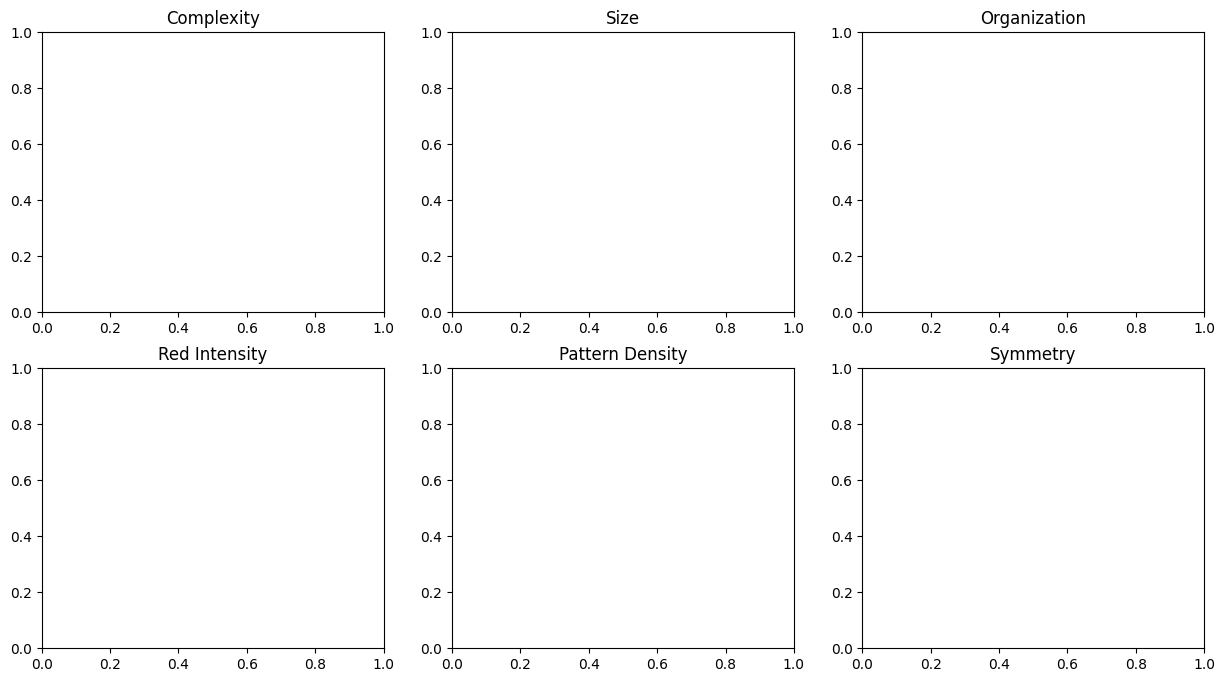

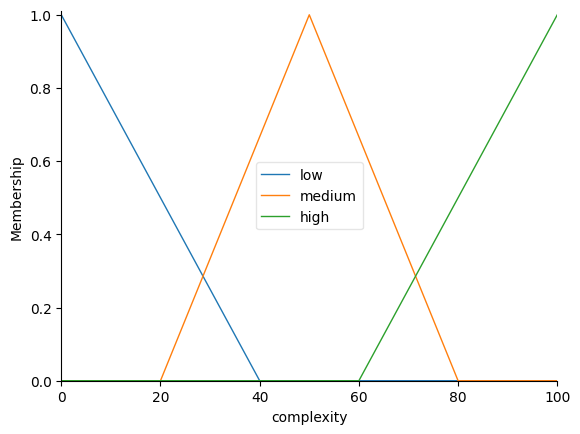

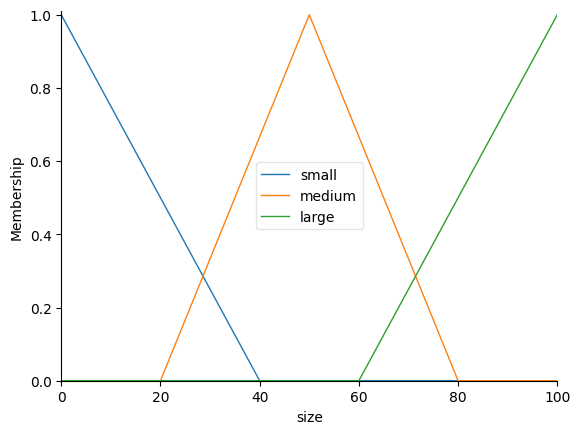

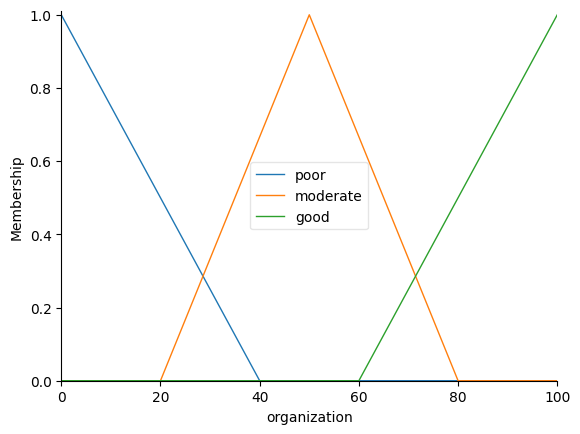

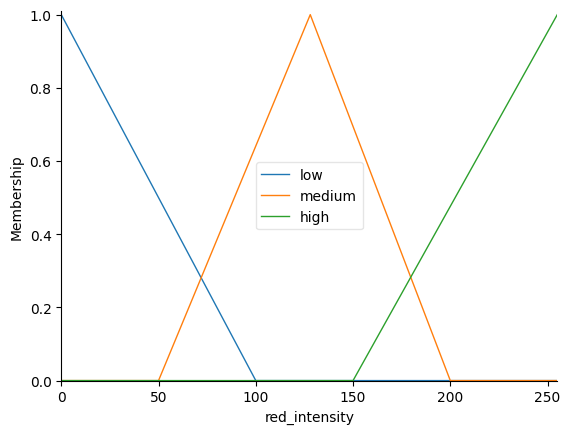

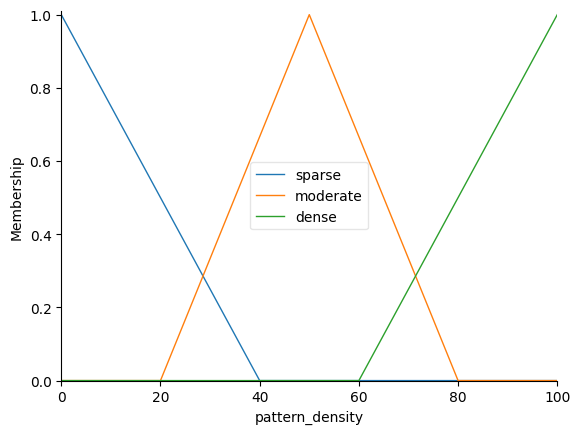

In [ ]:
# @title Fuzzy Logic Experiment

import numpy as np
!pip install -U scikit-fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


class FuzzyVisualMapper:

    def __init__(self):
        self.setup_fuzzy_system()

    def setup_fuzzy_system(self):

        self.complexity = ctrl.Antecedent(np.arange(0, 101, 1), 'complexity')
        self.complexity['low'] = fuzz.trimf(self.complexity.universe, [0, 0, 40])
        self.complexity['medium'] = fuzz.trimf(self.complexity.universe, [20, 50, 80])
        self.complexity['high'] = fuzz.trimf(self.complexity.universe, [60, 100, 100])


        self.size = ctrl.Antecedent(np.arange(0, 101, 1), 'size')
        self.size['small'] = fuzz.trimf(self.size.universe, [0, 0, 40])
        self.size['medium'] = fuzz.trimf(self.size.universe, [20, 50, 80])
        self.size['large'] = fuzz.trimf(self.size.universe, [60, 100, 100])


        self.organization = ctrl.Antecedent(np.arange(0, 101, 1), 'organization')
        self.organization['poor'] = fuzz.trimf(self.organization.universe, [0, 0, 40])
        self.organization['moderate'] = fuzz.trimf(self.organization.universe, [20, 50, 80])
        self.organization['good'] = fuzz.trimf(self.organization.universe, [60, 100, 100])


        self.red_intensity = ctrl.Consequent(np.arange(0, 256, 1), 'red_intensity')
        self.red_intensity['low'] = fuzz.trimf(self.red_intensity.universe, [0, 0, 100])
        self.red_intensity['medium'] = fuzz.trimf(self.red_intensity.universe, [50, 128, 200])
        self.red_intensity['high'] = fuzz.trimf(self.red_intensity.universe, [150, 255, 255])


        self.green_intensity = ctrl.Consequent(np.arange(0, 256, 1), 'green_intensity')
        self.green_intensity['low'] = fuzz.trimf(self.green_intensity.universe, [0, 0, 100])
        self.green_intensity['medium'] = fuzz.trimf(self.green_intensity.universe, [50, 128, 200])
        self.green_intensity['high'] = fuzz.trimf(self.green_intensity.universe, [150, 255, 255])


        self.blue_intensity = ctrl.Consequent(np.arange(0, 256, 1), 'blue_intensity')
        self.blue_intensity['low'] = fuzz.trimf(self.blue_intensity.universe, [0, 0, 100])
        self.blue_intensity['medium'] = fuzz.trimf(self.blue_intensity.universe, [50, 128, 200])
        self.blue_intensity['high'] = fuzz.trimf(self.blue_intensity.universe, [150, 255, 255])


        self.pattern_density = ctrl.Consequent(np.arange(0, 101, 1), 'pattern_density')
        self.pattern_density['sparse'] = fuzz.trimf(self.pattern_density.universe, [0, 0, 40])
        self.pattern_density['moderate'] = fuzz.trimf(self.pattern_density.universe, [20, 50, 80])
        self.pattern_density['dense'] = fuzz.trimf(self.pattern_density.universe, [60, 100, 100])


        self.symmetry = ctrl.Consequent(np.arange(0, 101, 1), 'symmetry')
        self.symmetry['asymmetric'] = fuzz.trimf(self.symmetry.universe, [0, 0, 40])
        self.symmetry['partial'] = fuzz.trimf(self.symmetry.universe, [20, 50, 80])
        self.symmetry['symmetric'] = fuzz.trimf(self.symmetry.universe, [60, 100, 100])


        self.rules = [
            ctrl.Rule(self.complexity['high'], self.red_intensity['high']),
            ctrl.Rule(self.complexity['medium'], self.red_intensity['medium']),
            ctrl.Rule(self.complexity['low'], self.red_intensity['low']),

            ctrl.Rule(self.organization['good'], self.green_intensity['high']),
            ctrl.Rule(self.organization['moderate'], self.green_intensity['medium']),
            ctrl.Rule(self.organization['poor'], self.green_intensity['low']),

            ctrl.Rule(self.size['large'], self.blue_intensity['high']),
            ctrl.Rule(self.size['medium'], self.blue_intensity['medium']),
            ctrl.Rule(self.size['small'], self.blue_intensity['low']),

            ctrl.Rule(self.complexity['high'] & self.size['large'], self.pattern_density['dense']),
            ctrl.Rule(self.complexity['low'] & self.size['small'], self.pattern_density['sparse']),
            ctrl.Rule(self.complexity['medium'] | self.size['medium'], self.pattern_density['moderate']),

            ctrl.Rule(self.organization['good'], self.symmetry['symmetric']),
            ctrl.Rule(self.organization['moderate'], self.symmetry['partial']),
            ctrl.Rule(self.organization['poor'], self.symmetry['asymmetric']),
        ]

        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulator = ctrl.ControlSystemSimulation(self.control_system)

    def extract_high_level_features(self, code_features):
        features = code_features * 100

        complexity = (
            features[3] * 0.3 +
            features[4] * 0.3 +
            features[10] * 0.2 +
            features[19] * 0.2
        )
        complexity = np.clip(complexity, 0, 100)

        size = (
            features[0] * 0.5 +
            features[1] * 0.3 +
            features[2] * 0.2
        )
        size = np.clip(size, 0, 100)

        organization = (
            features[14] * 0.3 +
            (100 - features[24]) * 0.3 +
            features[6] * 0.2 +
            (100 - features[10]) * 0.2
        )
        organization = np.clip(organization, 0, 100)

        return {
            'complexity': float(complexity),
            'size': float(size),
            'organization': float(organization)
        }

    def compute_visual_parameters(self, high_level_features):
        self.simulator.input['complexity'] = high_level_features['complexity']
        self.simulator.input['size'] = high_level_features['size']
        self.simulator.input['organization'] = high_level_features['organization']

        self.simulator.compute()

        return {
            'red': self.simulator.output['red_intensity'],
            'green': self.simulator.output['green_intensity'],
            'blue': self.simulator.output['blue_intensity'],
            'pattern_density': self.simulator.output['pattern_density'],
            'symmetry': self.simulator.output['symmetry']
        }

    def generate_image_with_fuzzy(self, code_features, image_size=32):
        high_level = self.extract_high_level_features(code_features)
        visual_params = self.compute_visual_parameters(high_level)

        image = np.zeros((image_size, image_size, 3))
        base_color = np.array([
            visual_params['red'] / 255.0,
            visual_params['green'] / 255.0,
            visual_params['blue'] / 255.0
        ])
        density = visual_params['pattern_density'] / 100.0
        symmetry = visual_params['symmetry'] / 100.0

        for i in range(image_size):
            for j in range(image_size):
                pattern = np.sin(i * density) * np.cos(j * density)
                if symmetry > 0.5:
                    pattern += np.sin((image_size - i) * density) * np.cos((image_size - j) * density)
                image[i, j] = base_color * (0.5 + 0.5 * pattern)

        image = np.clip(image, 0, 1)
        return image

    def visualize_membership_functions(self, save_path='results/fuzzy_membership.png'):
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        self.complexity.view(ax=axes[0, 0]); axes[0, 0].set_title('Complexity')
        self.size.view(ax=axes[0, 1]); axes[0, 1].set_title('Size')
        self.organization.view(ax=axes[0, 2]); axes[0, 2].set_title('Organization')
        self.red_intensity.view(ax=axes[1, 0]); axes[1, 0].set_title('Red Intensity')
        self.pattern_density.view(ax=axes[1, 1]); axes[1, 1].set_title('Pattern Density')
        self.symmetry.view(ax=axes[1, 2]); axes[1, 2].set_title('Symmetry')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Saved membership functions to: {save_path}")


class FuzzyEnhancedModel:

    def __init__(self, neural_model, fuzzy_mapper, blend_ratio=0.5):
        self.neural_model = neural_model
        self.fuzzy_mapper = fuzzy_mapper
        self.blend_ratio = blend_ratio

    def generate_image(self, code_features, device='cpu'):
        import torch
        self.neural_model.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(code_features).unsqueeze(0).to(device)
            if hasattr(self.neural_model, 'encode'):
                neural_image, _, _ = self.neural_model(features_tensor)
            else:
                neural_image = self.neural_model(features_tensor)
            neural_image = neural_image.cpu().numpy()[0].transpose(1, 2, 0)

        fuzzy_image = self.fuzzy_mapper.generate_image_with_fuzzy(
            code_features, image_size=neural_image.shape[0]
        )

        blended_image = (
            self.blend_ratio * neural_image + (1 - self.blend_ratio) * fuzzy_image
        )
        return np.clip(blended_image, 0, 1)

    def generate_batch(self, features_array, device='cpu'):
        images = []
        for features in features_array:
            img = self.generate_image(features, device)
            images.append(img)
        return np.array(images)


def compare_fuzzy_vs_neural(neural_model, features, num_samples=10,
                            save_path='results/fuzzy_comparison.png'):
    import torch
    fuzzy_mapper = FuzzyVisualMapper()
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    neural_model.eval()

    for i in range(num_samples):
        features_i = features[i]
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features_i).unsqueeze(0).to(device)
            if hasattr(neural_model, 'encode'):
                neural_image, _, _ = neural_model(features_tensor)
            else:
                neural_image = neural_model(features_tensor)
            neural_image = neural_image.cpu().numpy()[0].transpose(1, 2, 0)

        fuzzy_image = fuzzy_mapper.generate_image_with_fuzzy(features_i)
        blended = (neural_image + fuzzy_image) / 2

        axes[0, i].imshow(neural_image); axes[0, i].axis('off')
        if i == 0: axes[0, i].set_ylabel('Neural Network', fontsize=10)

        axes[1, i].imshow(fuzzy_image); axes[1, i].axis('off')
        if i == 0: axes[1, i].set_ylabel('Fuzzy Logic', fontsize=10)

        axes[2, i].imshow(blended); axes[2, i].axis('off')
        if i == 0: axes[2, i].set_ylabel('Blended', fontsize=10)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved comparison to: {save_path}")


def main():
    import os
    print("=" * 60)
    print("Fuzzy Logic")
    print("=" * 60)

    os.makedirs('results', exist_ok=True)
    print("\nSetting up fuzzy logic system...")
    fuzzy_mapper = FuzzyVisualMapper()

    print("Plotting membership functions...")
    fuzzy_mapper.visualize_membership_functions()

    print("\nTesting on sample features...")
    sample_features = np.random.rand(25)
    high_level = fuzzy_mapper.extract_high_level_features(sample_features)
    print("\nHigh-level features:")
    for key, value in high_level.items():
        print(f"  {key}: {value:.2f}")

    visual_params = fuzzy_mapper.compute_visual_parameters(high_level)
    print("\nVisual parameters:")
    for key, value in visual_params.items():
        print(f"  {key}: {value:.2f}")

    print("\nGenerating image...")
    image = fuzzy_mapper.generate_image_with_fuzzy(sample_features)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title('Generated Image with Fuzzy Logic')
    plt.axis('off')
    plt.savefig('results/fuzzy_sample.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("Saved sample image to: results/fuzzy_sample.png")

    print("\nGenerating multiple samples...")
    num_samples = 9
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for i in range(num_samples):
        features = np.random.rand(25)
        img = fuzzy_mapper.generate_image_with_fuzzy(features)
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        hl = fuzzy_mapper.extract_high_level_features(features)
        title = f"C:{hl['complexity']:.0f} S:{hl['size']:.0f} O:{hl['organization']:.0f}"
        ax.set_title(title, fontsize=8)
    plt.tight_layout()
    plt.savefig('results/fuzzy_samples.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("Saved multiple samples to: results/fuzzy_samples.png")

    print("\nDone.")


if __name__ == "__main__":
    main()


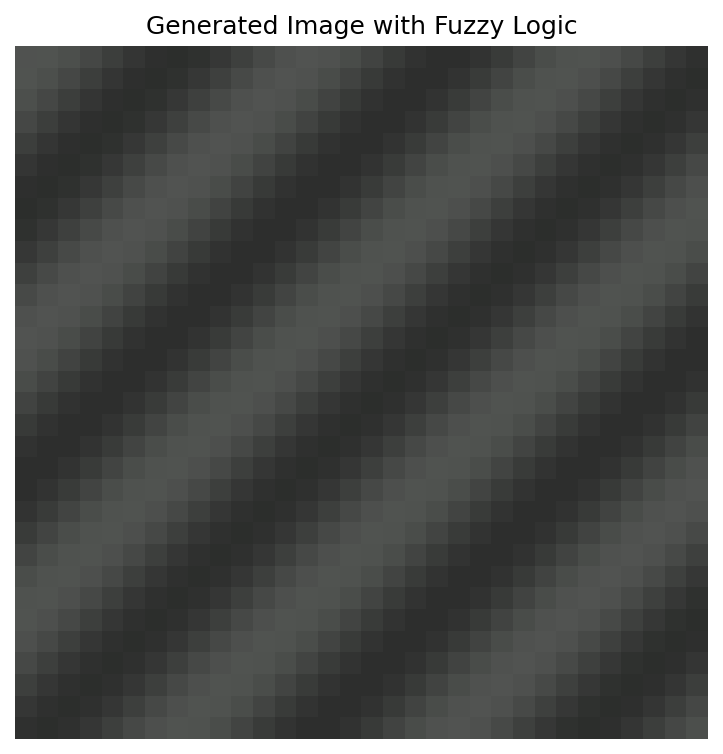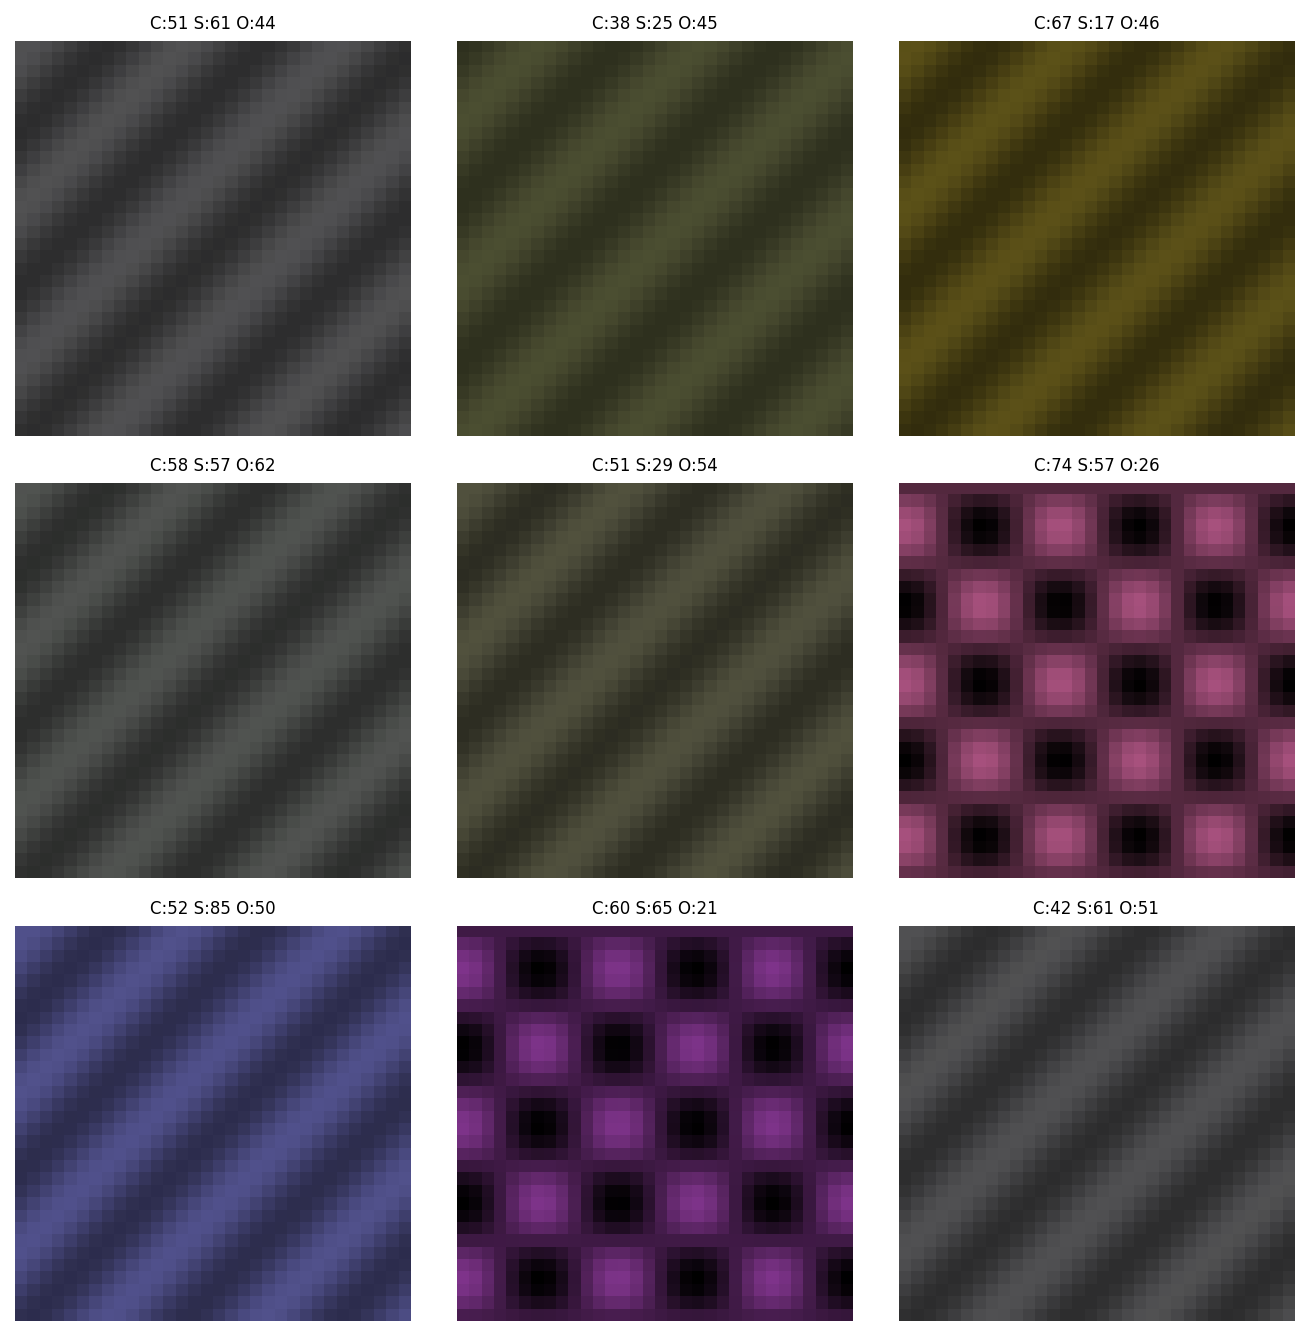

# **Evaluating**


---



In [ ]:
# @title Evaluater

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import pearsonr, spearmanr
import seaborn as sns


class CodeImageEvaluator:
    def __init__(self):
        self.metrics = {}

    def evaluate_clustering(self, images, n_clusters=5):
        print("Evaluating clustering quality...")

        n_samples = len(images)
        image_vectors = images.reshape(n_samples, -1)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(image_vectors)

        silhouette = silhouette_score(image_vectors, labels)
        calinski = calinski_harabasz_score(image_vectors, labels)
        davies_bouldin = davies_bouldin_score(image_vectors, labels)

        metrics = {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'davies_bouldin_score': davies_bouldin,
            'n_clusters': n_clusters
        }

        print(f"  Silhouette Score: {silhouette:.4f} (higher is better)")
        print(f"  Calinski-Harabasz: {calinski:.2f} (higher is better)")
        print(f"  Davies-Bouldin: {davies_bouldin:.4f} (lower is better)")

        self.metrics['clustering'] = metrics
        return metrics, labels

    def evaluate_similarity_preservation(self, code_features, images, sample_size=500):
        print("\nEvaluating similarity preservation...")

        n_samples = min(len(code_features), sample_size)
        indices = np.random.choice(len(code_features), n_samples, replace=False)
        features_sample = code_features[indices]
        images_sample = images[indices]

        image_vectors = images_sample.reshape(n_samples, -1)
        code_similarities = []
        image_similarities = []

        print("  Computing similarities...")
        for i in range(min(n_samples, 100)):
            for j in range(i + 1, min(n_samples, 100)):
                code_sim = 1 - cosine(features_sample[i], features_sample[j])
                code_similarities.append(code_sim)

                img_sim = 1 - cosine(image_vectors[i], image_vectors[j])
                image_similarities.append(img_sim)

        pearson_corr, pearson_p = pearsonr(code_similarities, image_similarities)
        spearman_corr, spearman_p = spearmanr(code_similarities, image_similarities)

        metrics = {
            'pearson_correlation': pearson_corr,
            'pearson_p_value': pearson_p,
            'spearman_correlation': spearman_corr,
            'spearman_p_value': spearman_p
        }

        print(f"  Pearson Correlation: {pearson_corr:.4f} (p={pearson_p:.4f})")
        print(f"  Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")

        self.metrics['similarity'] = metrics
        return metrics

    def evaluate_diversity(self, images):
        """Evaluate diversity across and within generated images."""
        print("\nEvaluating diversity...")

        n_samples = len(images)
        image_vectors = images.reshape(n_samples, -1)

        within_image_variance = np.var(images, axis=(1, 2, 3)).mean()

        pairwise_distances = []
        for i in range(min(n_samples, 100)):
            for j in range(i + 1, min(n_samples, 100)):
                dist = euclidean(image_vectors[i], image_vectors[j])
                pairwise_distances.append(dist)

        between_image_diversity = np.mean(pairwise_distances)

        color_diversity = {
            'red_std': np.std(images[:, :, :, 0]),
            'green_std': np.std(images[:, :, :, 1]),
            'blue_std': np.std(images[:, :, :, 2])
        }

        metrics = {
            'within_image_variance': within_image_variance,
            'between_image_diversity': between_image_diversity,
            'color_diversity': color_diversity
        }

        print(f"  Within-image Variance: {within_image_variance:.4f}")
        print(f"  Between-image Diversity: {between_image_diversity:.4f}")
        print(f"  Color Std - R: {color_diversity['red_std']:.4f}, "
              f"G: {color_diversity['green_std']:.4f}, "
              f"B: {color_diversity['blue_std']:.4f}")

        self.metrics['diversity'] = metrics
        return metrics

    def visualize_tsne(self, images, labels=None, save_path='results/tsne_visualization.png'):
        print("\nGenerating t-SNE visualization...")

        n_samples = len(images)
        image_vectors = images.reshape(n_samples, -1)

        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings = tsne.fit_transform(image_vectors)

        plt.figure(figsize=(10, 8))
        if labels is not None:
            scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                                  c=labels, cmap='viridis', alpha=0.6, s=50)
            plt.colorbar(scatter, label='Cluster')
        else:
            plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6, s=50, c='blue')

        plt.title('t-SNE Visualization of Generated Images', fontsize=14)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, alpha=0.3)

        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Saved t-SNE visualization to: {save_path}")

    def visualize_similarity_correlation(self, code_features, images,
                                         save_path='results/similarity_correlation.png'):
        print("\nPlotting similarity correlation...")

        n_samples = min(len(code_features), 200)
        indices = np.random.choice(len(code_features), n_samples, replace=False)
        features_sample = code_features[indices]
        images_sample = images[indices]
        image_vectors = images_sample.reshape(n_samples, -1)

        code_sims, image_sims = [], []
        for i in range(min(n_samples, 50)):
            for j in range(i + 1, min(n_samples, 50)):
                code_sim = 1 - cosine(features_sample[i], features_sample[j])
                img_sim = 1 - cosine(image_vectors[i], image_vectors[j])
                code_sims.append(code_sim)
                image_sims.append(img_sim)

        plt.figure(figsize=(10, 8))
        plt.scatter(code_sims, image_sims, alpha=0.5, s=30)
        z = np.polyfit(code_sims, image_sims, 1)
        p = np.poly1d(z)
        plt.plot(code_sims, p(code_sims), "r--", linewidth=2, label='Trend')

        corr, _ = pearsonr(code_sims, image_sims)
        plt.text(0.05, 0.95, f'Pearson r = {corr:.3f}',
                 transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.xlabel('Code Similarity')
        plt.ylabel('Image Similarity')
        plt.title('Code vs Image Similarity Correlation')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Saved correlation plot to: {save_path}")

    def generate_report(self, save_path='results/evaluation_report.txt'):
        print("\nGenerating evaluation report...")

        with open(save_path, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("Code-to-Image Evaluation Report\n")
            f.write("=" * 80 + "\n\n")

            for section in ['clustering', 'similarity', 'diversity']:
                if section in self.metrics:
                    f.write(f"{section.upper()} METRICS\n")
                    f.write("-" * 40 + "\n")
                    for key, value in self.metrics[section].items():
                        if isinstance(value, dict):
                            f.write(f"{key}:\n")
                            for k, v in value.items():
                                f.write(f"  {k}: {v}\n")
                        else:
                            f.write(f"{key}: {value}\n")
                    f.write("\n")

            f.write("=" * 80 + "\n")

        print(f"Report saved to: {save_path}")


def main():
    import os
    import torch
    from tqdm import tqdm
    # i will just add the class imp here
    # ------
    import torch.nn as nn
    import torch.nn.functional as F
    class Generator(nn.Module):
        def __init__(self, input_dim=25, image_size=256):
            super().__init__()
            self.image_size = image_size

            # Feature grouping
            self.structure_idx = [0, 1, 2, 10, 19, 20]
            self.control_idx = [3, 4, 9]
            self.operations_idx = [5, 7, 8, 6]
            self.style_idx = [14, 15, 24, 23]
            self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]

            # Separate encoders for different frequency bands
            self.low_freq_encoder = nn.Sequential(
                nn.Linear(len(self.structure_idx), 256),
                nn.LayerNorm(256),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(256, 512)
            )

            self.mid_freq_encoder = nn.Sequential(
                nn.Linear(len(self.control_idx) + len(self.operations_idx), 256),
                nn.LayerNorm(256),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(256, 512)
            )

            self.high_freq_encoder = nn.Sequential(
                nn.Linear(len(self.style_idx) + len(self.advanced_idx), 256),
                nn.LayerNorm(256),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(256, 512)
            )

            self.color_palette_net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.LayerNorm(128),
                nn.Tanh(),
                nn.Linear(128, 12)
            )

            # Spatial composition network
            self.composition_net = nn.Sequential(
                nn.Linear(512, 256),
                nn.LayerNorm(256),
                nn.GELU(),
                nn.Linear(256, 6)
            )

            # Calculate base spatial sizes dynamically
            self.base_size = 8
            self.num_upsamples = int(np.log2(image_size / self.base_size))

            # Projection to initial spatial maps
            self.low_to_spatial = nn.Linear(512, self.base_size * self.base_size * 128)
            self.mid_to_spatial = nn.Linear(512, (self.base_size * 2) * (self.base_size * 2) * 64)
            self.high_to_spatial = nn.Linear(512, (self.base_size * 4) * (self.base_size * 4) * 32)

            # Progressive upsampling blocks
            self.low_decoder = self._build_progressive_decoder(128, self.num_upsamples)
            self.mid_decoder = self._build_progressive_decoder(64, self.num_upsamples - 1)
            self.high_decoder = self._build_progressive_decoder(32, self.num_upsamples - 2)

            # Fusion network
            self.fusion = nn.Sequential(
                nn.Conv2d(96, 64, 3, 1, 1),
                nn.GroupNorm(8, 64),
                nn.GELU(),
                nn.Conv2d(64, 32, 3, 1, 1),
                nn.GroupNorm(8, 32),
                nn.GELU(),
                nn.Conv2d(32, 3, 1)
            )

            # Perlin noise strength controller
            self.noise_strength = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

            self._initialize_weights()

        def _build_progressive_decoder(self, in_channels, num_upsamples):
            layers = []
            current_channels = in_channels

            for i in range(num_upsamples):
                out_channels = max(32, current_channels // 2)
                layers.extend([
                    nn.ConvTranspose2d(current_channels, out_channels, 4, 2, 1),
                    nn.GroupNorm(min(8, out_channels), out_channels),
                    nn.GELU()
                ])
                current_channels = out_channels

            if current_channels != 32:
                layers.extend([
                    nn.Conv2d(current_channels, 32, 3, 1, 1),
                    nn.GroupNorm(8, 32),
                    nn.GELU()
                ])

            return nn.Sequential(*layers)

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.xavier_uniform_(m.weight, gain=0.5)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

        def generate_perlin_noise(self, batch_size, size, device):
            grid_size = max(4, size // 64)
            grid = torch.randn(batch_size, 2, grid_size, grid_size, device=device)
            noise = F.interpolate(grid, size=(size, size), mode='bicubic', align_corners=True)
            return noise[:, 0:1]

        def apply_color_palette(self, grayscale, palette):
            batch_size = grayscale.size(0)
            palette = palette.view(batch_size, 4, 3)

            gray_norm = (grayscale + 1) / 2

            colors = []
            for i in range(3):
                channel_colors = palette[:, :, i]
                stops = torch.linspace(0, 1, 4, device=grayscale.device)

                result = torch.zeros_like(gray_norm)
                for j in range(3):
                    mask = (gray_norm >= stops[j]) & (gray_norm < stops[j+1])
                    t = (gray_norm - stops[j]) / (stops[j+1] - stops[j] + 1e-8)
                    result += mask * (channel_colors[:, j:j+1, None, None] * (1-t) +
                                    channel_colors[:, j+1:j+2, None, None] * t)

                mask_last = gray_norm >= stops[-1]
                result += mask_last * channel_colors[:, -1:, None, None]

                colors.append(result)

            return torch.cat(colors, dim=1)

        def forward(self, x):
            batch_size = x.size(0)
            device = x.device

            # Extract feature groups
            structure = x[:, self.structure_idx]
            control = x[:, self.control_idx]
            operations = x[:, self.operations_idx]
            style = x[:, self.style_idx]
            advanced = x[:, self.advanced_idx]

            # Encode to frequency
            low_freq = self.low_freq_encoder(structure)
            mid_freq = self.mid_freq_encoder(torch.cat([control, operations], dim=1))
            high_freq = self.high_freq_encoder(torch.cat([style, advanced], dim=1))

            palette = self.color_palette_net(x)

            # Generate composition
            composition_params = self.composition_net(low_freq)
            composition_params = torch.tanh(composition_params)

            # Project
            low_spatial = self.low_to_spatial(low_freq).view(
                batch_size, 128, self.base_size, self.base_size
            )
            mid_spatial = self.mid_to_spatial(mid_freq).view(
                batch_size, 64, self.base_size * 2, self.base_size * 2
            )
            high_spatial = self.high_to_spatial(high_freq).view(
                batch_size, 32, self.base_size * 4, self.base_size * 4
            )

            #Decode each frequency to target resolution
            low_decoded = self.low_decoder(low_spatial)
            mid_decoded = self.mid_decoder(mid_spatial)
            high_decoded = self.high_decoder(high_spatial)

            target_size = (self.image_size, self.image_size)
            if low_decoded.shape[2:] != target_size:
                low_decoded = F.interpolate(low_decoded, size=target_size, mode='bilinear', align_corners=False)
            if mid_decoded.shape[2:] != target_size:
                mid_decoded = F.interpolate(mid_decoded, size=target_size, mode='bilinear', align_corners=False)
            if high_decoded.shape[2:] != target_size:
                high_decoded = F.interpolate(high_decoded, size=target_size, mode='bilinear', align_corners=False)

            # Apply transformations
            theta = composition_params[:, 3:4]
            scale = 0.5 + composition_params[:, 2:3]
            tx, ty = composition_params[:, 0:1], composition_params[:, 1:2]

            cos_t = torch.cos(theta * 3.14159)
            sin_t = torch.sin(theta * 3.14159)
            affine_matrix = torch.zeros(batch_size, 2, 3, device=device)
            affine_matrix[:, 0, 0] = cos_t.squeeze() * scale.squeeze()
            affine_matrix[:, 0, 1] = -sin_t.squeeze() * scale.squeeze()
            affine_matrix[:, 1, 0] = sin_t.squeeze() * scale.squeeze()
            affine_matrix[:, 1, 1] = cos_t.squeeze() * scale.squeeze()
            affine_matrix[:, 0, 2] = tx.squeeze()
            affine_matrix[:, 1, 2] = ty.squeeze()

            grid = F.affine_grid(affine_matrix, low_decoded.size(), align_corners=False)
            low_decoded = F.grid_sample(low_decoded, grid, align_corners=False, padding_mode='reflection')

            # Merge frequency bands
            merged = torch.cat([low_decoded, mid_decoded, high_decoded], dim=1)
            fused = self.fusion(merged)

            # Add Perlin noise
            noise_scale = self.noise_strength(x)
            perlin = self.generate_perlin_noise(batch_size, self.image_size, device)
            perlin = perlin.expand(-1, 3, -1, -1)
            fused = fused + noise_scale.view(-1, 1, 1, 1) * perlin * 0.3

            # Convert to grayscale
            grayscale = fused.mean(dim=1, keepdim=True)

            colored = self.apply_color_palette(grayscale, palette)

            output = torch.tanh(colored)

            return output
    # ------
    print("=" * 60)
    print("Evaluating Code-to-Image Model")
    print("=" * 60)

    os.makedirs('results', exist_ok=True)

    print("\nLoading features...")
    features = np.load('data/features.npy')
    print(f"Loaded {len(features)} samples")

    print("\nLoading model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Generator()

    try:
        checkpoint = torch.load('models/model_256.pth', map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        print("Model loaded successfully.")
    except:
        print("Warning: no saved model found. Using random weights..")

    model.to(device)
    model.eval()

    batch_size = 32
    all_images = []

    with torch.no_grad():
        for i in tqdm(range(0, len(features), batch_size)):
            batch = features[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            images_tensor = model(batch_tensor)
            batch_images = images_tensor.cpu().numpy().transpose(0, 2, 3, 1)
            all_images.append(batch_images)

    images = np.concatenate(all_images, axis=0)
    print(f"Generated {len(images)} images")

    evaluator = CodeImageEvaluator()

    print("\n" + "=" * 60)
    print("Starting full evaluation")
    print("=" * 60)

    clustering_metrics, labels = evaluator.evaluate_clustering(images)
    similarity_metrics = evaluator.evaluate_similarity_preservation(features, images)
    diversity_metrics = evaluator.evaluate_diversity(images)

    print("\n" + "=" * 60)
    print("Generating visualizations")
    print("=" * 60)

    evaluator.visualize_tsne(images, labels)
    evaluator.visualize_similarity_correlation(features, images)
    evaluator.generate_report()

    print("\nEvaluation completed successfully.")


if __name__ == "__main__":
    main()


Evaluating Code-to-Image Model

Loading features...
Loaded 2000 samples

Loading model...
Model loaded successfully.


100%|██████████| 63/63 [15:35<00:00, 14.84s/it]


Generated 2000 images

Starting full evaluation
Evaluating clustering quality...
  Silhouette Score: 0.2801 (higher is better)
  Calinski-Harabasz: 1526.63 (higher is better)
  Davies-Bouldin: 1.5203 (lower is better)

Evaluating similarity preservation...
  Computing similarities...
  Pearson Correlation: 0.9219 (p=0.0000)
  Spearman Correlation: 0.8018 (p=0.0000)

Evaluating diversity...
  Within-image Variance: 0.4039
  Between-image Diversity: 361.5004
  Color Std - R: 0.7103, G: 0.6220, B: 0.6984

Generating visualizations

Generating t-SNE visualization...
Saved t-SNE visualization to: results/tsne_visualization.png

Plotting similarity correlation...
Saved correlation plot to: results/similarity_correlation.png

Generating evaluation report...
Report saved to: results/evaluation_report.txt

Evaluation completed successfully.


# **Utils**


---



In [ ]:
# @title Converting one file to one image
import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

class FeatureDrivenCNNGenerator(nn.Module):
    def __init__(self, input_dim=25, image_size=256):
        super().__init__()
        self.image_size = image_size

        self.structure_idx = [0, 1, 2, 10, 19, 20]
        self.control_idx = [3, 4, 9]
        self.operations_idx = [5, 7, 8, 6]
        self.style_idx = [14, 15, 24, 23]
        self.advanced_idx = [12, 13, 16, 17, 18, 11, 21, 22]

        self.structure_encoder = nn.Sequential(
            nn.Linear(len(self.structure_idx), 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2)
        )

        self.control_encoder = nn.Sequential(
            nn.Linear(len(self.control_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.operations_encoder = nn.Sequential(
            nn.Linear(len(self.operations_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.style_encoder = nn.Sequential(
            nn.Linear(len(self.style_idx), 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2)
        )

        self.advanced_encoder = nn.Sequential(
            nn.Linear(len(self.advanced_idx), 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2)
        )

        total_latent = 256 + 128 + 128 + 128 + 256

        self.to_spatial = nn.Sequential(
            nn.Linear(total_latent, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 4 * 4 * 256),
            nn.LayerNorm(4 * 4 * 256),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.size(0)

        structure_features = x[:, self.structure_idx]
        control_features = x[:, self.control_idx]
        operations_features = x[:, self.operations_idx]
        style_features = x[:, self.style_idx]
        advanced_features = x[:, self.advanced_idx]

        structure_latent = self.structure_encoder(structure_features)
        control_latent = self.control_encoder(control_features)
        operations_latent = self.operations_encoder(operations_features)
        style_latent = self.style_encoder(style_features)
        advanced_latent = self.advanced_encoder(advanced_features)

        combined_latent = torch.cat([
            structure_latent,
            control_latent,
            operations_latent,
            style_latent,
            advanced_latent
        ], dim=1)

        spatial_flat = self.to_spatial(combined_latent)
        spatial_map = spatial_flat.view(batch_size, 256, 4, 4)

        img = self.decoder(spatial_map)

        return img

class CodeToImageGenerator:

    def __init__(self, model_path, device=None):

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(device)

        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)

        self.model = FeatureDrivenCNNGenerator(input_dim=25, image_size=256)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.to(self.device)
        self.model.eval()

        print(f"Model loaded successfully on {self.device}")

        self.feature_mean = None
        self.feature_std = None

    def set_normalization_stats(self, training_features):
        self.feature_mean = training_features.mean(axis=0)
        self.feature_std = training_features.std(axis=0) + 1e-8
        print("Normalization statistics set from training data")

    def normalize_features(self, features):

        if self.feature_mean is None or self.feature_std is None:
            raise ValueError(
                "Normalization statistics not set. "
            )

        return (features - self.feature_mean) / self.feature_std

    def generate(self, features, normalize=True):
        if features.ndim == 1:
            features = features.reshape(1, -1)

        if normalize:
            features = self.normalize_features(features)

        features_tensor = torch.FloatTensor(features).to(self.device)

        with torch.no_grad():
            image_tensor = self.model(features_tensor)

        image = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
        image = (image + 1) / 2
        image = np.clip(image, 0, 1)

        return image

    def generate_batch(self, features_batch, normalize=True):
        if normalize:
            features_batch = self.normalize_features(features_batch)

        features_tensor = torch.FloatTensor(features_batch).to(self.device)

        with torch.no_grad():
            images_tensor = self.model(features_tensor)

        images = images_tensor.cpu().permute(0, 2, 3, 1).numpy()
        images = (images + 1) / 2
        images = np.clip(images, 0, 1)

        return images

    def save_image(self, image, output_path, size=None):

        image_uint8 = (image * 255).astype(np.uint8)
        pil_image = Image.fromarray(image_uint8)

        if size is not None:
            pil_image = pil_image.resize(size, Image.LANCZOS)

        os.makedirs(os.path.dirname(output_path) if os.path.dirname(output_path) else ".", exist_ok=True)
        pil_image.save(output_path)
        print(f"Image saved to {output_path}")

    def save_batch(self, images, output_dir, prefix="image", size=None):
        os.makedirs(output_dir, exist_ok=True)

        for i, image in enumerate(images):
            output_path = os.path.join(output_dir, f"{prefix}_{i:04d}.png")
            self.save_image(image, output_path, size=size)

        print(f"Saved {len(images)} images to {output_dir}")


# ===================== Example Usage =====================

def run():
    print("Code-to-Image Generator - Production Example")

    generator = CodeToImageGenerator("models/model_256.pth")

    training_features = np.load("data/features.npy")
    print(training_features[0])

    generator.set_normalization_stats(training_features)

    # new_features = np.array([
    #     197, 16, 3, 4, 3, 39, 7, 19, 8, 0, 13, 335.125, 102, 0,
    #     0.030456852791878174, 0.2378218796129244, 0, 0, 1, 7, 8,
    #     8063.933384878806, 0.2949852507374631,
    #     40.69655172413793, 3.9810251489563675
    # ]) -> model_code.png
    new_features = [1.97000000e+02, 1.60000000e+01, 3.00000000e+00, 4.00000000e+00,
3.00000000e+00, 3.90000000e+01, 7.00000000e+00, 1.90000000e+01,
 8.00000000e+00, 0.00000000e+00, 1.30000000e+01, 3.35125000e+02,
 1.02000000e+02, 0.00000000e+00, 3.04568528e-02, 2.37821880e-01,
 0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 7.00000000e+00,
 8.00000000e+00, 8.06393338e+03, 2.94985251e-01, 4.06965517e+01,
 3.98102515e+00] #-> model_loss_code.png

    #new_features = training_features[0]

    image = generator.generate(new_features, normalize=True)
    generator.save_image(image, "output/model_loss_code.png", size=(256, 256))

    batch_features = training_features[:5]
    batch_images = generator.generate_batch(batch_features, normalize=True)
    generator.save_batch(batch_images, "output/batch", prefix="code", size=(256, 256))


def generate_image_from_features(features, model_path, training_features, output_path=None):
    generator = CodeToImageGenerator(model_path)
    generator.set_normalization_stats(training_features)
    image = generator.generate(features, normalize=True)

    if output_path:
        generator.save_image(image, output_path)

    return image


if __name__ == "__main__":
    run()

Code-to-Image Generator - Production Example

[1/4] Initializing generator...
Loading model from code2art/models/chotic.pth...


RuntimeError: Error(s) in loading state_dict for FeatureDrivenCNNGenerator:
	Missing key(s) in state_dict: "structure_encoder.0.weight", "structure_encoder.0.bias", "structure_encoder.1.weight", "structure_encoder.1.bias", "structure_encoder.3.weight", "structure_encoder.3.bias", "structure_encoder.4.weight", "structure_encoder.4.bias", "control_encoder.0.weight", "control_encoder.0.bias", "control_encoder.1.weight", "control_encoder.1.bias", "control_encoder.3.weight", "control_encoder.3.bias", "control_encoder.4.weight", "control_encoder.4.bias", "operations_encoder.0.weight", "operations_encoder.0.bias", "operations_encoder.1.weight", "operations_encoder.1.bias", "operations_encoder.3.weight", "operations_encoder.3.bias", "operations_encoder.4.weight", "operations_encoder.4.bias", "style_encoder.0.weight", "style_encoder.0.bias", "style_encoder.1.weight", "style_encoder.1.bias", "style_encoder.3.weight", "style_encoder.3.bias", "style_encoder.4.weight", "style_encoder.4.bias", "advanced_encoder.0.weight", "advanced_encoder.0.bias", "advanced_encoder.1.weight", "advanced_encoder.1.bias", "advanced_encoder.3.weight", "advanced_encoder.3.bias", "advanced_encoder.4.weight", "advanced_encoder.4.bias", "to_spatial.0.weight", "to_spatial.0.bias", "to_spatial.1.weight", "to_spatial.1.bias", "to_spatial.3.weight", "to_spatial.3.bias", "to_spatial.4.weight", "to_spatial.4.bias", "decoder.0.weight", "decoder.0.bias", "decoder.1.weight", "decoder.1.bias", "decoder.1.running_mean", "decoder.1.running_var", "decoder.3.weight", "decoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.4.running_mean", "decoder.4.running_var", "decoder.6.weight", "decoder.6.bias", "decoder.7.weight", "decoder.7.bias", "decoder.7.running_mean", "decoder.7.running_var", "decoder.9.weight", "decoder.9.bias", "decoder.10.weight", "decoder.10.bias", "decoder.10.running_mean", "decoder.10.running_var", "decoder.12.weight", "decoder.12.bias". 
	Unexpected key(s) in state_dict: "low_freq_encoder.0.weight", "low_freq_encoder.0.bias", "low_freq_encoder.1.weight", "low_freq_encoder.1.bias", "low_freq_encoder.4.weight", "low_freq_encoder.4.bias", "mid_freq_encoder.0.weight", "mid_freq_encoder.0.bias", "mid_freq_encoder.1.weight", "mid_freq_encoder.1.bias", "mid_freq_encoder.4.weight", "mid_freq_encoder.4.bias", "high_freq_encoder.0.weight", "high_freq_encoder.0.bias", "high_freq_encoder.1.weight", "high_freq_encoder.1.bias", "high_freq_encoder.4.weight", "high_freq_encoder.4.bias", "color_palette_net.0.weight", "color_palette_net.0.bias", "color_palette_net.1.weight", "color_palette_net.1.bias", "color_palette_net.3.weight", "color_palette_net.3.bias", "composition_net.0.weight", "composition_net.0.bias", "composition_net.1.weight", "composition_net.1.bias", "composition_net.3.weight", "composition_net.3.bias", "low_to_spatial.weight", "low_to_spatial.bias", "mid_to_spatial.weight", "mid_to_spatial.bias", "high_to_spatial.weight", "high_to_spatial.bias", "low_decoder.0.weight", "low_decoder.0.bias", "low_decoder.1.weight", "low_decoder.1.bias", "low_decoder.3.weight", "low_decoder.3.bias", "low_decoder.4.weight", "low_decoder.4.bias", "mid_decoder.0.weight", "mid_decoder.0.bias", "mid_decoder.1.weight", "mid_decoder.1.bias", "high_decoder.0.weight", "high_decoder.0.bias", "high_decoder.1.weight", "high_decoder.1.bias", "fusion.0.weight", "fusion.0.bias", "fusion.1.weight", "fusion.1.bias", "fusion.3.weight", "fusion.3.bias", "fusion.4.weight", "fusion.4.bias", "fusion.6.weight", "fusion.6.bias", "noise_strength.0.weight", "noise_strength.0.bias", "noise_strength.2.weight", "noise_strength.2.bias". 